In [1]:
%%time
%load_ext autoreload
%autoreload 2
import mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os

/home/yuchia/anaconda3/envs/toycoronagraph/lib/python3.11/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/yuchia/anaconda3/envs/toycoronagraph/lib/python3.11/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


CPU times: user 710 ms, sys: 747 ms, total: 1.46 s
Wall time: 2.55 s


In [2]:
file_dir='para/test/'

In [3]:
target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 56.875 # in lambda/D #455*0.125
system_distance = 10 #pc

final_dir='/mnt/chia/APLC/'
wavelength = 575e-9 # meter
D = 6
inc = 0
psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
view_in_AU = psf_scale * target_pixel * system_distance
print(psf_scale, psf_scale*455/448/2,view_in_AU)

0.002470880491500521 0.0012547439995901082 11.242506236327369


In [4]:
par = mcfost.Paramfile(file_dir+'solar.para')
print(par)

3.0                       mcfost version

#Number of photon packages
  1e+05                   nbr_photons_eq_th  : T computation
  10000                   nbr_photons_lambda : SED computation
  1e+05                   nbr_photons_image : images computation

#Wavelength
  150 0.1   3000          n_lambda, lambda_min, lambda_max [microns]
  T T T                   compute temperature?, compute sed?, use default wavelength grid ?
  IMLup.lambda           wavelength file (if previous parameter is F)
  T T                     separation of different contributions?, stokes parameters?

#Grid geometry and size
  1                       1 = cylindrical, 2 = spherical, 3 = Voronoi tesselation (this is in beta, please ask Christophe)
  100  70  1 20           n_rad (log distribution), nz (or n_theta), n_az, n_rad_in

#Maps
  455 455  11.2        grid (nx,ny), size [AU]
  0.0   0.0    1 F    RT: imin, imax, n_incl, centered ?
  0.0   0.0    1    RT: az_min, az_max, n_az
  10.00                  

In [5]:
def print_line(file_name, line_number):
    """Changes the line at the given line number in the given file to the given new text."""
    with open(file_name, "r") as file:
        lines = file.readlines()
    print(lines[line_number - 1])
# Example usage
print_line(file_dir+"solar.para", 20)

  0. 0.  1  F          RT: imin, imax, n_incl, centered ?  



In [6]:
def change_line(file_name, line_number, new_text):
    """Changes the line at the given line number in the given file to the given new text."""
    with open(file_name, "r") as file:
        lines = file.readlines()
        
    lines[line_number - 1] = new_text
    with open(file_name, "w") as file:
        file.writelines(lines)

In [10]:
%%time
# Systems in different distances
import itertools
import os
import shutil

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D

wavelengths_nm = [575] # meter
SDs = [7.99, 8.41, 8.88, 9.40, 9.99, 10.66, 11.42, 12.30, 13.32, 14.53, 15.98, 17.76, 19.98, 22.84, 26.64, 31.97] # system distance in pc
def SDs_name(SD):
    return str(int(SD*100))
Ds = {"3m": 3} # aperture size in meter
incs = [0]
for system_distance, wavelength_nm, D_name, inc in itertools.product(SDs, wavelengths_nm, Ds, incs):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    # Coronagraph setting
    view_in_AU = psf_scale * target_pixel * system_distance
    new_file_dir=file_dir+SDs_name(system_distance)+"/"
    try:os.mkdir(new_file_dir)
    except:pass
    shutil.copyfile(file_dir+"solar.para", new_file_dir+"solar.para")
    filename = new_file_dir+"solar.para"
    change_line(filename,19,"  455 455 {:.1f}            grid (nx,ny), size [AU]\n".format(view_in_AU))
    change_line(filename,20,"  {:.1f} {:.1f}  1  F          RT: imin, imax, n_incl, centered ?\n".format(inc, inc))
    change_line(filename,22,"  {:.2f}                  distance (pc)\n".format(system_distance))
    wavelength_mum=[wavelength_nm/1000]
    mcfost.run_one_file(filename, wavelengths=wavelength_mum, move_to_subdir=False)
    model = mcfost.ModelResults(new_file_dir)
    fits_result=model.images[str(wavelength_mum[0])]
    fits_result.writeto(file_dir+SDs_name(system_distance)+"_30.fits")

mcfost    : INFO     Running MCFOST for: para/test/799/solar.para
mcfost    : INFO     Computing SED for para/test/799/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/799/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/799/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/841/solar.para
mcfost    : INFO     Computing SED for para/test/841/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/841/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/841/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/888/solar.para
mcfost    : INFO     Computing SED for para/test/888/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/888/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/888/solar.para
mcfost    : INFO 

CPU times: user 532 ms, sys: 199 ms, total: 730 ms
Wall time: 25min 16s


In [9]:
%%time
# Systems in different distances
import itertools
import os
import shutil

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D

wavelengths_nm = [575] # meter
SDs = [7.99, 8.41, 8.88, 9.40, 9.99, 10.66, 11.42, 12.30, 13.32, 14.53, 15.98, 17.76, 19.98, 22.84, 26.64, 31.97] # system distance in pc
def SDs_name(SD):
    return str(int(SD*100))
Ds = {"3m": 3} # aperture size in meter
incs = [60]
for system_distance, wavelength_nm, D_name, inc in itertools.product(SDs, wavelengths_nm, Ds, incs):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    # Coronagraph setting
    view_in_AU = psf_scale * target_pixel * system_distance
    new_file_dir=file_dir+SDs_name(system_distance)+"/"
    try:os.mkdir(new_file_dir)
    except:pass
    shutil.copyfile(file_dir+"solar.para", new_file_dir+"solar.para")
    filename = new_file_dir+"solar.para"
    change_line(filename,19,"  455 455 {:.1f}            grid (nx,ny), size [AU]\n".format(view_in_AU))
    change_line(filename,20,"  {:.1f} {:.1f}  1  F          RT: imin, imax, n_incl, centered ?\n".format(inc, inc))
    change_line(filename,22,"  {:.2f}                  distance (pc)\n".format(system_distance))
    wavelength_mum=[wavelength_nm/1000]
    mcfost.run_one_file(filename, wavelengths=wavelength_mum, move_to_subdir=False)
    model = mcfost.ModelResults(new_file_dir)
    fits_result=model.images[str(wavelength_mum[0])]
    fits_result.writeto(file_dir+SDs_name(system_distance)+"_360.fits")

mcfost    : INFO     Running MCFOST for: para/test/799/solar.para
mcfost    : INFO     Computing SED for para/test/799/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/799/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/799/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/841/solar.para
mcfost    : INFO     Computing SED for para/test/841/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/841/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/841/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/888/solar.para
mcfost    : INFO     Computing SED for para/test/888/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/888/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/888/solar.para
mcfost    : INFO 

CPU times: user 577 ms, sys: 214 ms, total: 791 ms
Wall time: 22min 20s


In [ ]:
%%time
# Systems in different distances
import itertools
import os
import shutil

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D

wavelengths_nm = [575] # meter
SDs = [8.53, 8.70, 8.88, 9.07, 9.27, 9.47, 9.69, 9.91, 10.15, 10.40, 10.66, 10.93, 11.22, 11.52, 11.84, 12.18, 12.54, 12.92, 13.32, 13.75, 14.21, 14.70, 15.22, 15.79, 16.39, 17.05, 17.76, 18.53, 19.38, 20.30, 21.31, 22.43, 23.68, 25.07, 26.64, 28.42, 30.45, 32.79, 35.52, 38.75, 42.63, 47.36, 53.28] # system distance in pc
def SDs_name(SD):
    return str(int(SD*100))
Ds = {"8m": 8} # aperture size in meter
incs = [0]
for system_distance, wavelength_nm, D_name, inc in itertools.product(SDs, wavelengths_nm, Ds, incs):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    # Coronagraph setting
    view_in_AU = psf_scale * target_pixel * system_distance
    new_file_dir=file_dir+SDs_name(system_distance)+"/"
    try:os.mkdir(new_file_dir)
    except:pass
    shutil.copyfile(file_dir+"solar.para", new_file_dir+"solar.para")
    filename = new_file_dir+"solar.para"
    change_line(filename,19,"  455 455 {:.1f}            grid (nx,ny), size [AU]\n".format(view_in_AU))
    change_line(filename,20,"  {:.1f} {:.1f}  1  F          RT: imin, imax, n_incl, centered ?\n".format(inc, inc))
    change_line(filename,22,"  {:.2f}                  distance (pc)\n".format(system_distance))
    wavelength_mum=[wavelength_nm/1000]
    mcfost.run_one_file(filename, wavelengths=wavelength_mum, move_to_subdir=False)
    model = mcfost.ModelResults(new_file_dir)
    fits_result=model.images[str(wavelength_mum[0])]
    fits_result.writeto(file_dir+SDs_name(system_distance)+"_80.fits")

mcfost    : INFO     Running MCFOST for: para/test/852/solar.para
mcfost    : INFO     Computing SED for para/test/852/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/852/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/852/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/869/solar.para
mcfost    : INFO     Computing SED for para/test/869/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/869/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/869/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/888/solar.para
mcfost    : INFO     Computing SED for para/test/888/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/888/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/888/solar.para
mcfost    : INFO 

CPU times: user 1.95 s, sys: 590 ms, total: 2.54 s
Wall time: 1h 18min 55s


In [8]:
%%time
# Systems in different distances
import itertools
import os
import shutil

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D

wavelengths_nm = [575] # meter
SDs = [8.88, 9.13, 9.40, 9.69, 9.99, 10.31, 10.66, 11.02, 11.42, 11.84, 12.30, 12.79, 13.32, 13.90, 14.53, 15.22, 15.98, 16.83, 17.76, 18.81, 19.98, 21.31, 22.84, 24.59, 26.64, 29.06, 31.97] # system distance in pc
def SDs_name(SD):
    return str(int(SD*100))
Ds = {"6m": 6} # aperture size in meter
incs = [0]
for system_distance, wavelength_nm, D_name, inc in itertools.product(SDs, wavelengths_nm, Ds, incs):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    # Coronagraph setting
    view_in_AU = psf_scale * target_pixel * system_distance
    new_file_dir=file_dir+SDs_name(system_distance)+"/"
    try:os.mkdir(new_file_dir)
    except:pass
    shutil.copyfile(file_dir+"solar.para", new_file_dir+"solar.para")
    filename = new_file_dir+"solar.para"
    change_line(filename,19,"  455 455 {:.1f}            grid (nx,ny), size [AU]\n".format(view_in_AU))
    change_line(filename,20,"  {:.1f} {:.1f}  1  F          RT: imin, imax, n_incl, centered ?\n".format(inc, inc))
    change_line(filename,22,"  {:.2f}                  distance (pc)\n".format(system_distance))
    wavelength_mum=[wavelength_nm/1000]
    mcfost.run_one_file(filename, wavelengths=wavelength_mum, move_to_subdir=False)
    model = mcfost.ModelResults(new_file_dir)
    fits_result=model.images[str(wavelength_mum[0])]
    fits_result.writeto(file_dir+SDs_name(system_distance)+"_60.fits")

mcfost    : INFO     Running MCFOST for: para/test/888/solar.para
mcfost    : INFO     Computing SED for para/test/888/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/888/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/888/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/913/solar.para
mcfost    : INFO     Computing SED for para/test/913/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/913/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/913/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/940/solar.para
mcfost    : INFO     Computing SED for para/test/940/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/940/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/940/solar.para
mcfost    : INFO 

CPU times: user 1.18 s, sys: 367 ms, total: 1.54 s
Wall time: 49min 12s


In [ ]:
%%time
#APLC
import itertools
import os
import shutil

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 56.875 # in lambda/D #455*0.125
system_distance = 10 #pc

final_dir='/mnt/chia/APLC/'
wavelengths_nm = [575,660,730,825] # meter
Ds = {"3m": 3, "6m": 6, "8m": 8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90]
for wavelength_nm, D_name, inc in itertools.product(wavelengths_nm, Ds, incs):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    # Coronagraph setting
    view_in_AU = psf_scale * target_pixel * system_distance
    new_file_dir=final_dir+str(wavelength_nm)+D_name+str(inc)+"/"
    try:os.mkdir(new_file_dir)
    except:pass
    shutil.copyfile(file_dir+"solar.para", new_file_dir+"solar.para")
    filename = new_file_dir+"solar.para"
    change_line(filename,19,"  1365 1365 {:.1f}            grid (nx,ny), size [AU]\n".format(view_in_AU))
    change_line(filename,20,"  {:.1f} {:.1f}  1  F          RT: imin, imax, n_incl, centered ?\n".format(inc, inc))
    wavelength_mum=[wavelength_nm/1000]
    mcfost.run_one_file(filename, wavelengths=wavelength_mum, move_to_subdir=False)
    model = mcfost.ModelResults(new_file_dir)
    fits_result=model.images[str(wavelength_mum[0])]
    fits_result.writeto(final_dir+str(wavelength_nm)+D_name+str(inc)+".fits")

mcfost    : INFO     Running MCFOST for: /mnt/chia/APLC/5753m0/solar.para
mcfost    : INFO     Computing SED for /mnt/chia/APLC/5753m0/solar.para
mcfost    : INFO     SED results written to /mnt/chia/APLC/5753m0/data_th
mcfost    : INFO     Computing image at 0.575 microns for /mnt/chia/APLC/5753m0/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: /mnt/chia/APLC/5753m15/solar.para
mcfost    : INFO     Computing SED for /mnt/chia/APLC/5753m15/solar.para
mcfost    : INFO     SED results written to /mnt/chia/APLC/5753m15/data_th
mcfost    : INFO     Computing image at 0.575 microns for /mnt/chia/APLC/5753m15/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: /mnt/chia/APLC/5753m30/solar.para
mcfost    : INFO     Computing SED for /mnt/chia/APLC/5753m30/solar.para
mcfost    : INFO     SED results written to /mnt/chia/APLC/5753m30/data_th
mcfost    : INFO     Computing image at 0.575 microns for /mnt/ch

CPU times: user 23.9 s, sys: 6.84 s, total: 30.8 s
Wall time: 2h 28min 14s


In [ ]:
%%time
import itertools
import os
import shutil

target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D
system_distance = 10 #pc

wavelengths_nm = [575,660,730,825] # meter
#Ds = {"Roman":2.4,"LUVOIRA":15} # aperture size in meters
#Ds = {"HWO":6.5,"LUVOIRB":8} # aperture size in meters
Ds = {"3m": 3, "6m": 6, "8m": 8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90]
for wavelength_nm, D_name, inc in itertools.product(wavelengths_nm, Ds, incs):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    # Coronagraph setting
    view_in_AU = psf_scale * target_pixel * system_distance
    new_file_dir=file_dir+str(wavelength_nm)+D_name+str(inc)+"/"
    try:os.mkdir(new_file_dir)
    except:pass
    shutil.copyfile(file_dir+"solar.para", new_file_dir+"solar.para")
    filename = new_file_dir+"solar.para"
    change_line(filename,19,"  1365 1365 {:.1f}            grid (nx,ny), size [AU]\n".format(view_in_AU))
    change_line(filename,20,"  {:.1f} {:.1f}  1  F          RT: imin, imax, n_incl, centered ?\n".format(inc, inc))
    wavelength_mum=[wavelength_nm/1000]
    mcfost.run_one_file(filename, wavelengths=wavelength_mum, move_to_subdir=False)
    model = mcfost.ModelResults(new_file_dir)
    fits_result=model.images[str(wavelength_mum[0])]
    fits_result.writeto(file_dir+str(wavelength_nm)+D_name+str(inc)+".fits")

mcfost    : INFO     Running MCFOST for: para/test/5753m0/solar.para
mcfost    : INFO     Computing SED for para/test/5753m0/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/5753m0/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/5753m0/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/5753m15/solar.para
mcfost    : INFO     Computing SED for para/test/5753m15/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/5753m15/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/5753m15/solar.para
mcfost    : INFO     Calculation complete.
mcfost    : INFO     Running MCFOST for: para/test/5753m30/solar.para
mcfost    : INFO     Computing SED for para/test/5753m30/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/5753m30/data_th
mcfost    : INFO     Computing image at 0.575 microns for pa

In [9]:
%%time
res = mcfost.run_one_file(file_dir+'solar.para', wavelengths=[0.575], move_to_subdir=False)

mcfost    : INFO     Running MCFOST for: para/test/solar.para
mcfost    : INFO     Computing SED for para/test/solar.para
mcfost    : INFO     SED results written to /home/yuchia/github/para/test/data_th
mcfost    : INFO     Computing image at 0.575 microns for para/test/solar.para
mcfost    : INFO     Calculation complete.


CPU times: user 9.01 ms, sys: 0 ns, total: 9.01 ms
Wall time: 1min 27s


In [18]:
model = mcfost.ModelResults(file_dir)
print(model)
print(list(model._wavelengths_lookup.values()))
model.describe()

<MCFOST ModelResults in directory '/home/yuchia/github/para/test'>
['0.575']
Model results in /home/yuchia/github/para/test for solar.para
    Model has 1 inclinations from 59.99999999999999 to 59.99999999999999
    SED computed from 0.1 - 3000.0 microns using 150 wavelengths
    Images computed for 1 wavelengths: [0.575] micron


### Apeature size effect

In [19]:
# conversion & units
rad_to_arcsecond = 206264.806247
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy
light_speed = 299792458 # m/s

# calculation
psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
xpix=(np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scale
ypix=(np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scale
F_transfer = jy*wavelength/light_speed/psf_scale**2
view_in_AU = psf_scale * target_pixel * 10
print("View in AU: {:.2f}".format(view_in_AU))

View in AU: 11.24


In [20]:
raw_img = model.images[str(0.575)]
origin = np.reshape(raw_img.data[5,0],(target_pixel,target_pixel))
F_v = origin*F_transfer # F_v(Jy/arcsec^2)
np.max(F_v)

0.151492

1.0183447218491692

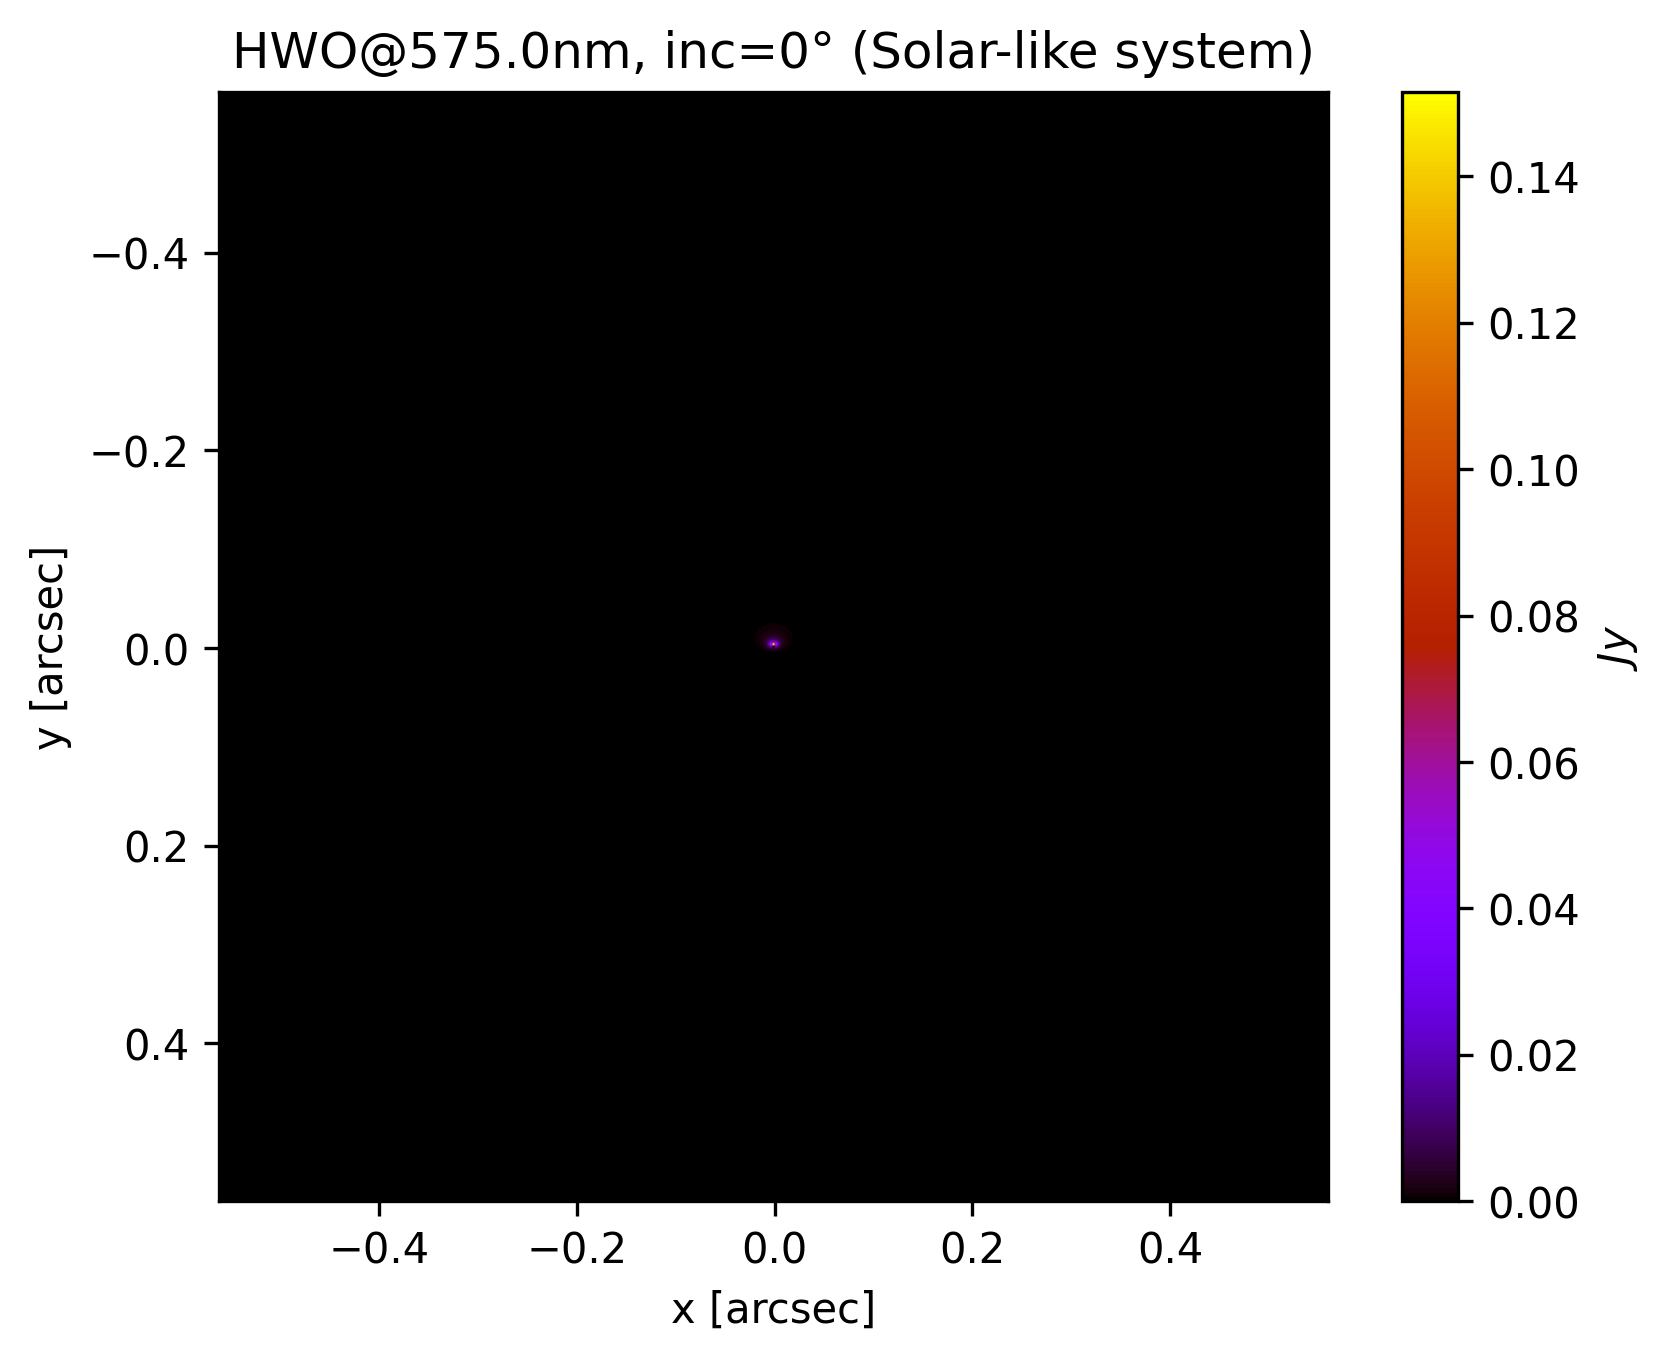

In [21]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(F_v.astype(np.float64),
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
plt.title("{}@{}nm, inc={}\N{degree sign} (Solar-like system)".format("HWO", wavelength*1e9, inc))
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')
np.sum(F_v.astype(np.float64))

(896, 896)
0.22078906348288443


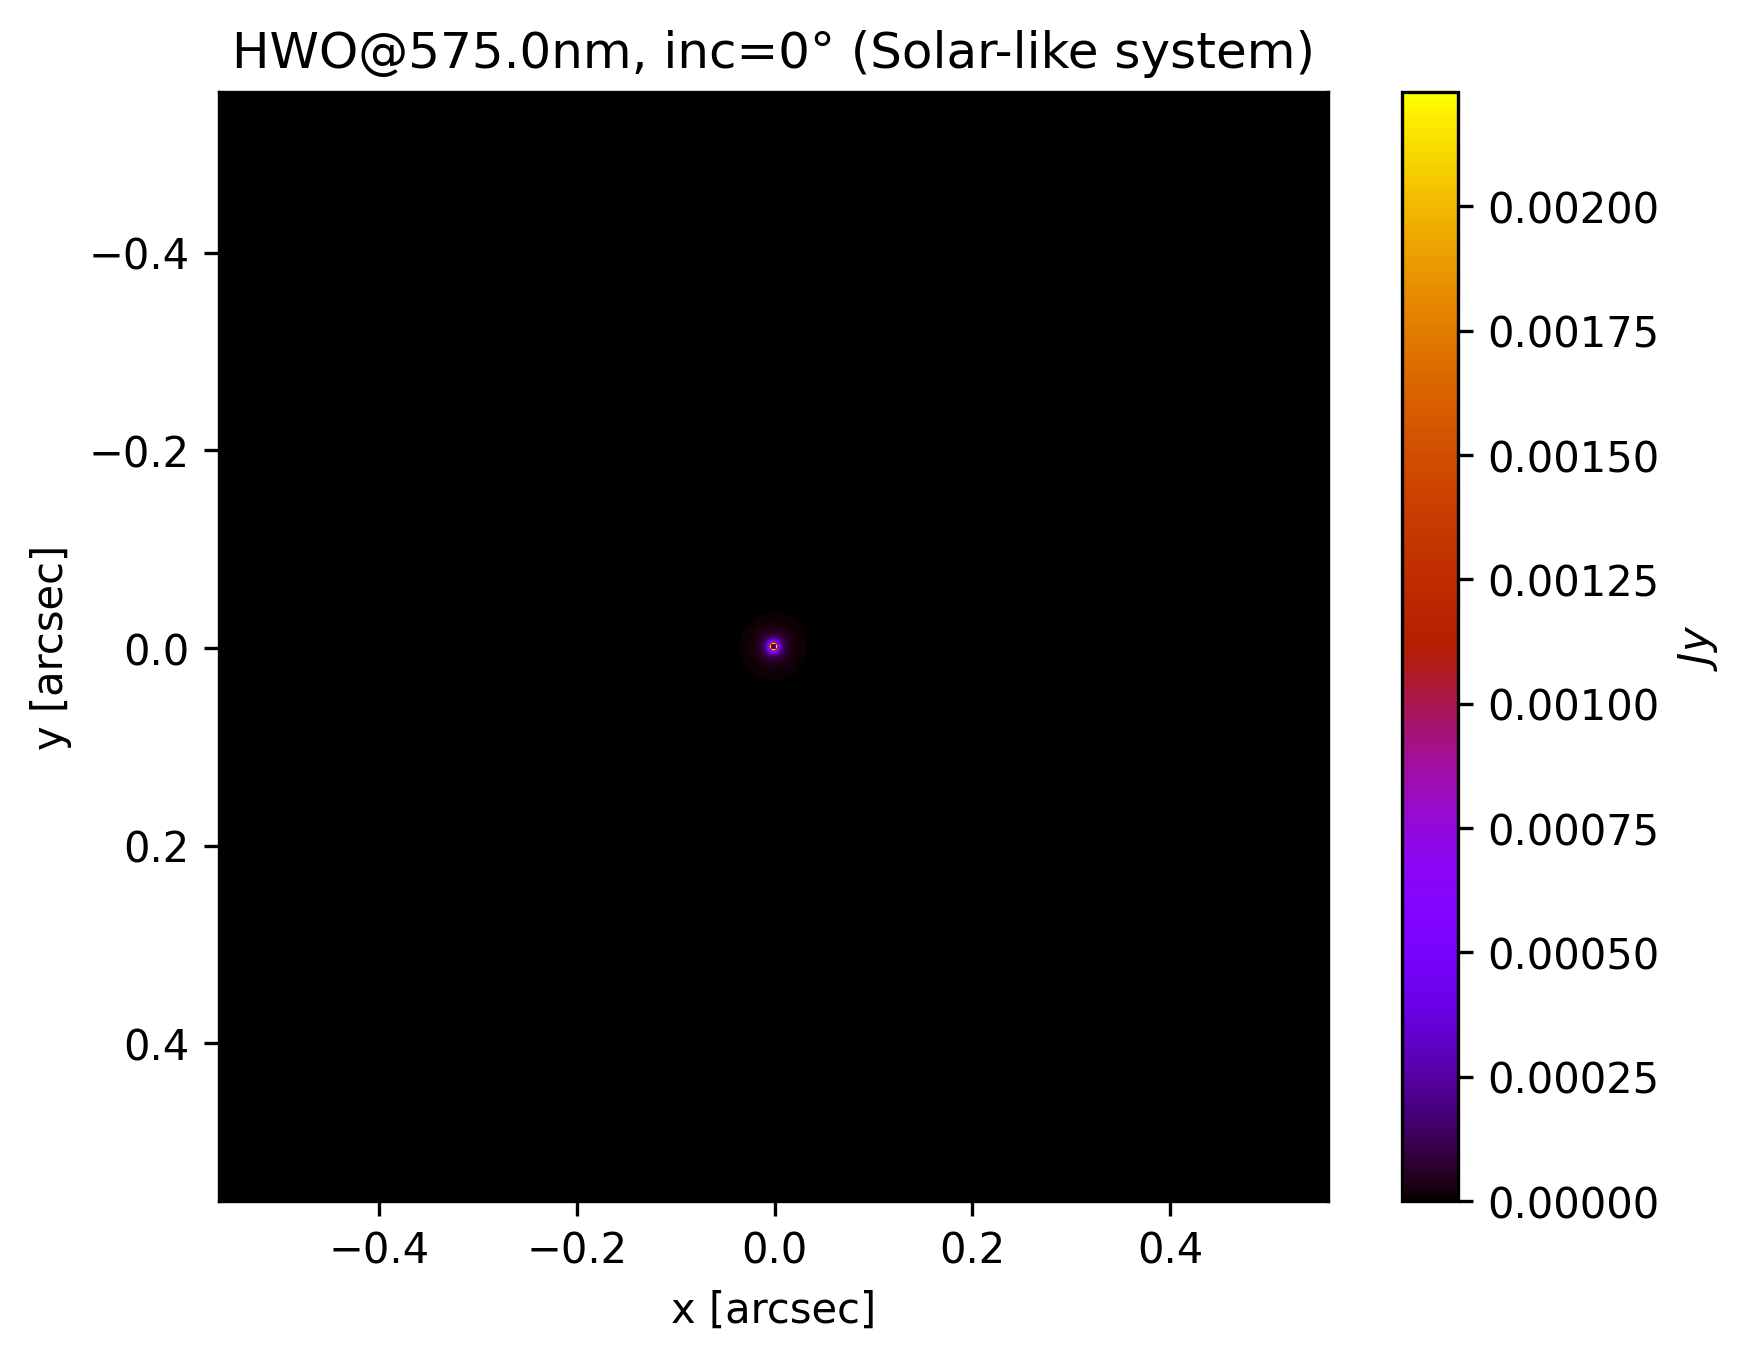

In [22]:
from scipy.io import readsav
sav_data = readsav("1zodi0.sav") # the inner radius truncation is determined by the sublimation, 0.0287629 au
print(np.shape(sav_data['inu']))
#1zodi.sav shows the case with 0.1 au truncation
#1 zodi
#896*896
#1.2547439995901082 mas per pixel
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow((1000/2.887)**2*sav_data['inu'],
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
plt.title("{}@{}nm, inc={}\N{degree sign} (Solar-like system)".format("HWO", wavelength*1e9, inc))
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')
print(np.sum((1000/2.887)**2*sav_data['inu']))

(1e-08, 0.02)

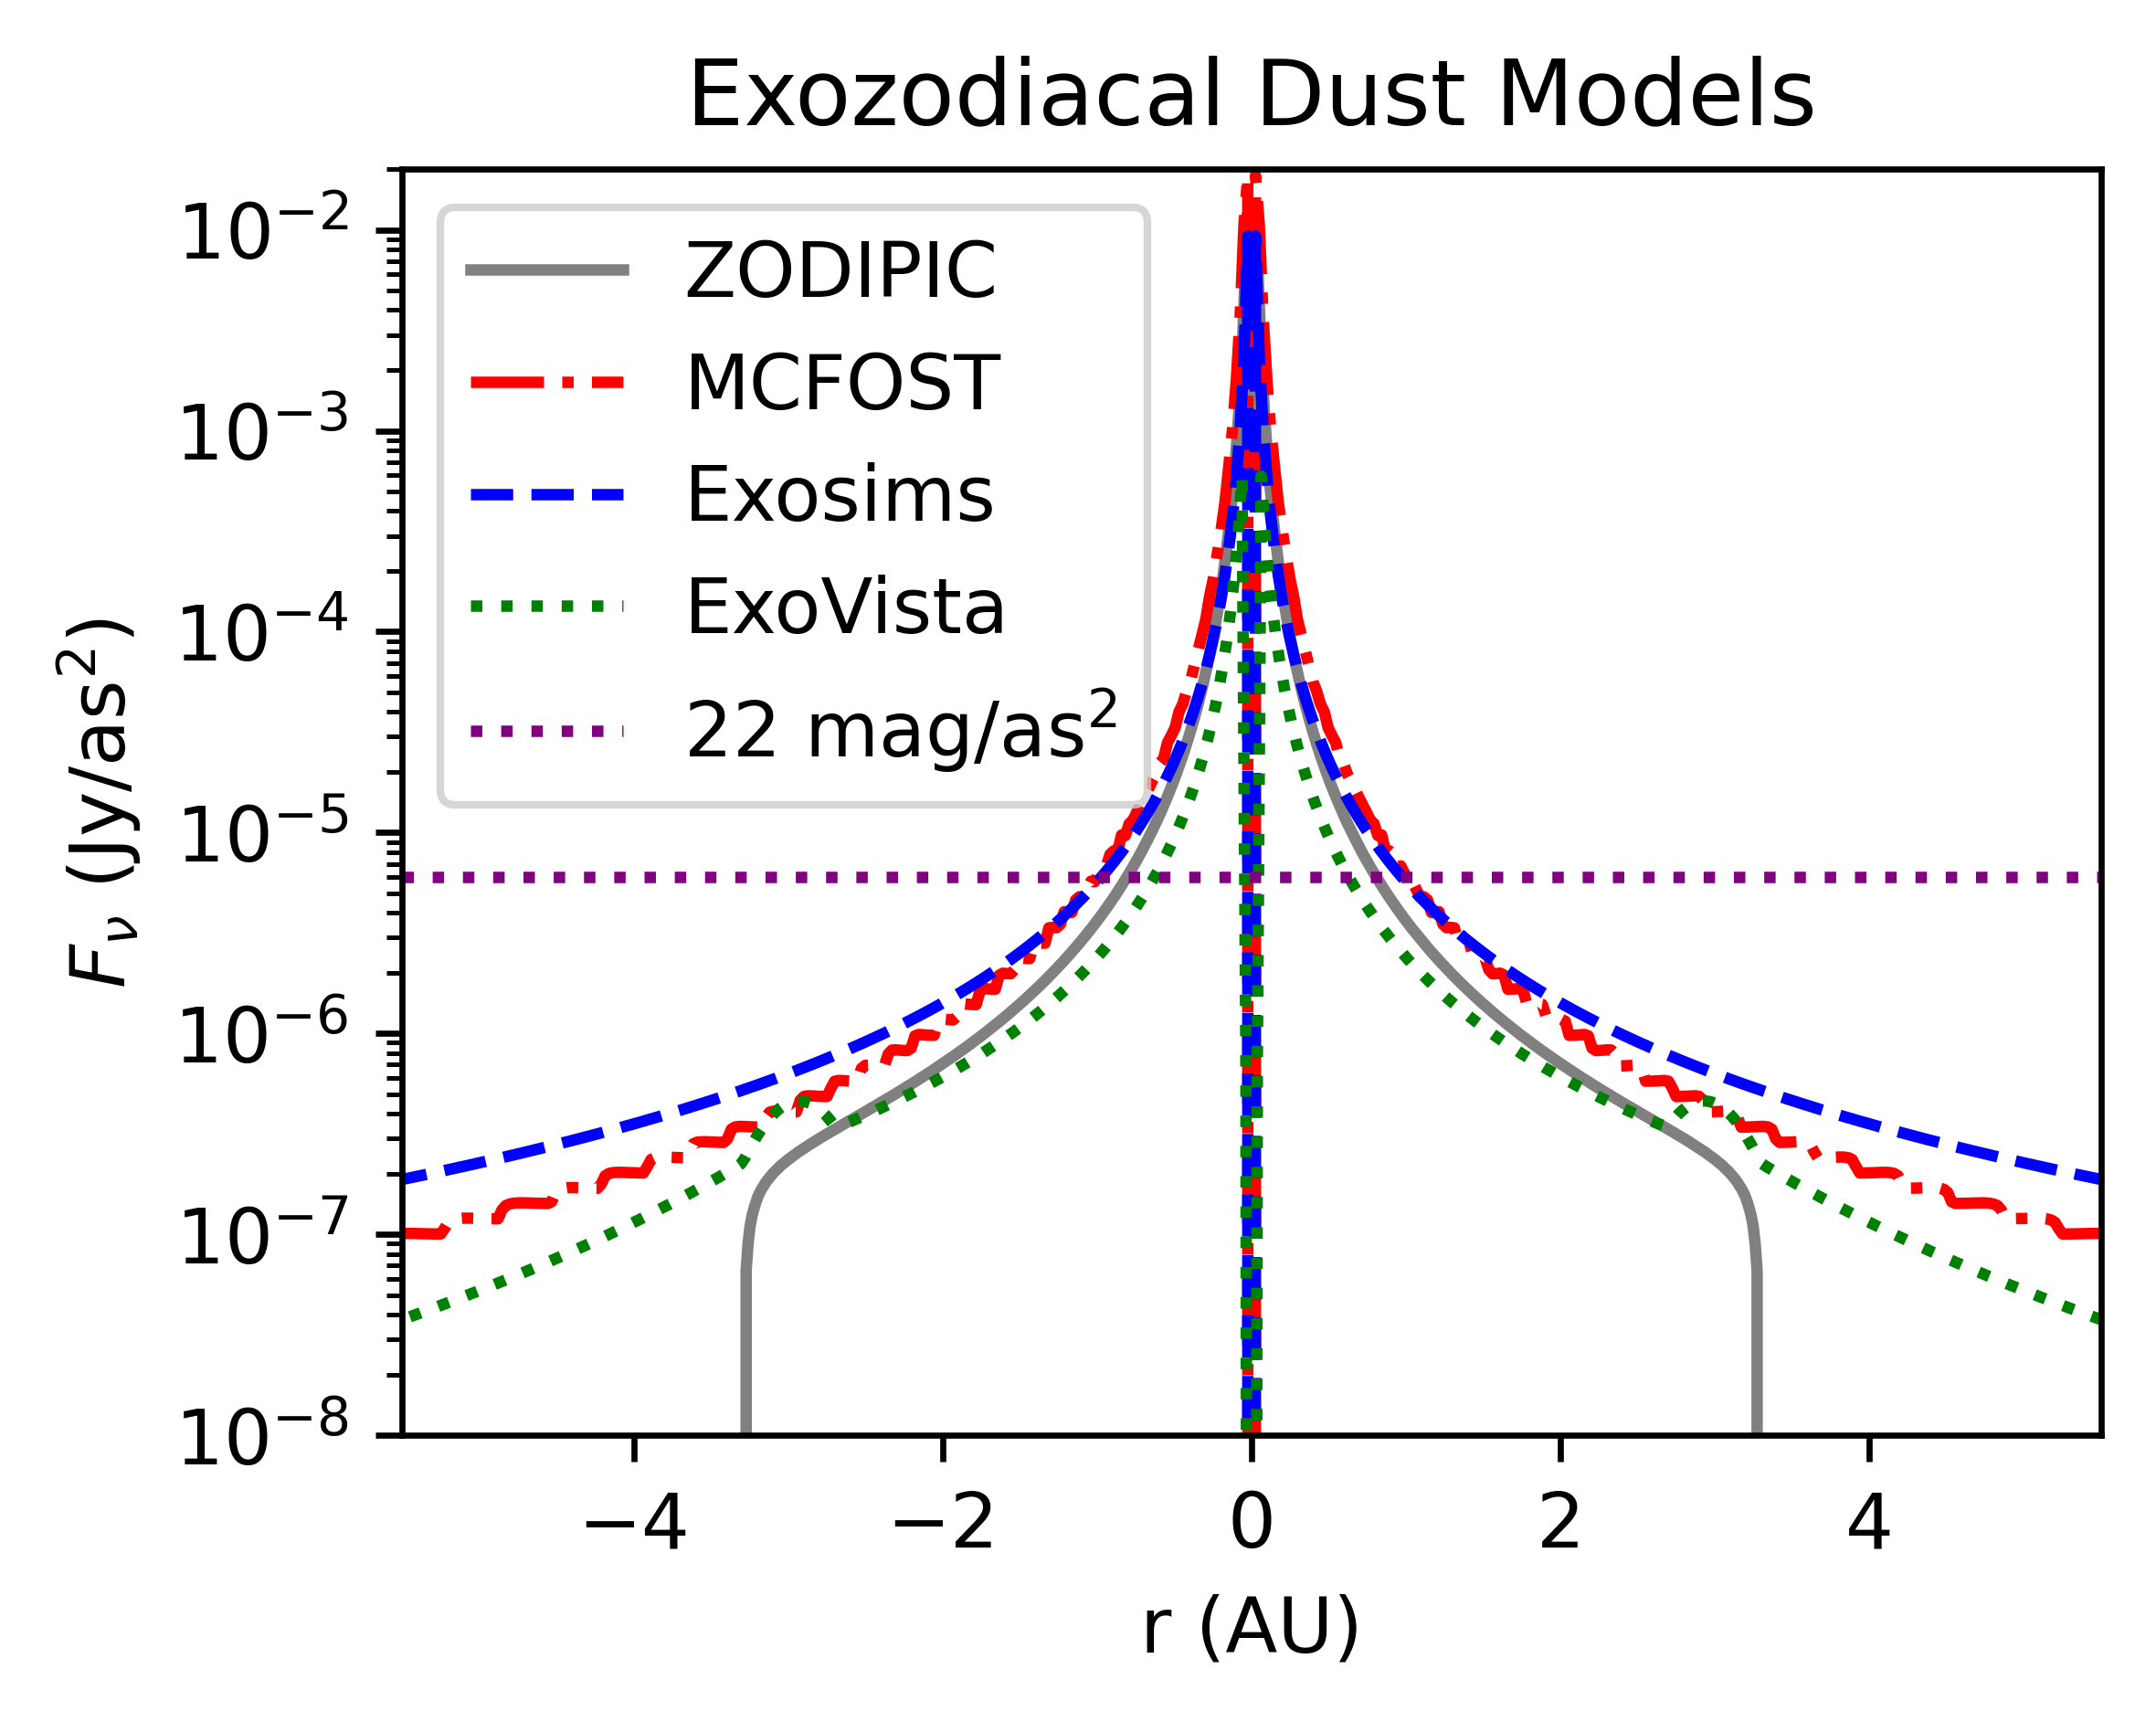

In [31]:
# Define the image
from turtle import color
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(4, 3), dpi=600)

# MCFOST results comparison with the results from the ZODIPIC model
# ZODIPIC
x1 = np.linspace(-view_in_AU/2,view_in_AU/2,896)
sav_data = readsav("1zodi0.sav") # the inner radius truncation is determined by the sublimation, 0.0287629 au
plt.plot(x1,(1000/1.2547439995901082)**2*sav_data['inu'][896//2], label='ZODIPIC', color='gray')

# MCFOST
x2 = np.linspace(-view_in_AU/2,view_in_AU/2,455)
plt.plot(x2,F_v.astype(np.float64)[227], label='MCFOST', linestyle='-.', color='red')

# Exosims
#np.save('exosims_disk_model.npy', np.array([np.arange(-pixel_number//2+1, pixel_number//2+1, 1)*pixel_scale*1000, exosims_disk_model[pixel_number//2, :]]))
exosims = np.load('Toy_Coronagraph/tests/exosims0.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x3 = exosims[0]/1000*10
plt.plot(x3, exosims[1], label='Exosims', linestyle='--', color='blue')

# ExoVista
exovista = np.load('Toy_Coronagraph/tests/exovista0.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x4 = exovista[0]/1000*10
plt.plot(x4, exovista[1], label='ExoVista', linestyle=':', color='green')

# Uniform disk
# 1 zodi = 22 mag/as^2 in V band
# 22 mag/as^2 in V band is 5.99e-6 Jy/as^2 (Johnson UBVRI+)
plt.axhline(y=5.99e-6, color='purple', linestyle=':', label=r'22 mag/as$^2$')


# Add axis units Jy/arcs^2
plt.xlabel('r (AU)')
plt.ylabel(r'$F_{\nu}$ (Jy/as$^2$)')

# Add title 
plt.title('Exozodiacal Dust Models')

# Show the labels
plt.legend(loc='upper left')
    
# log scale
plt.yscale('log')

# Set the limits
plt.xlim(-5.5, 5.5)
plt.ylim(1e-8, 0.02)

# Save the plot with dpi 300
#fig.savefig('disk_models.png', dpi=600)

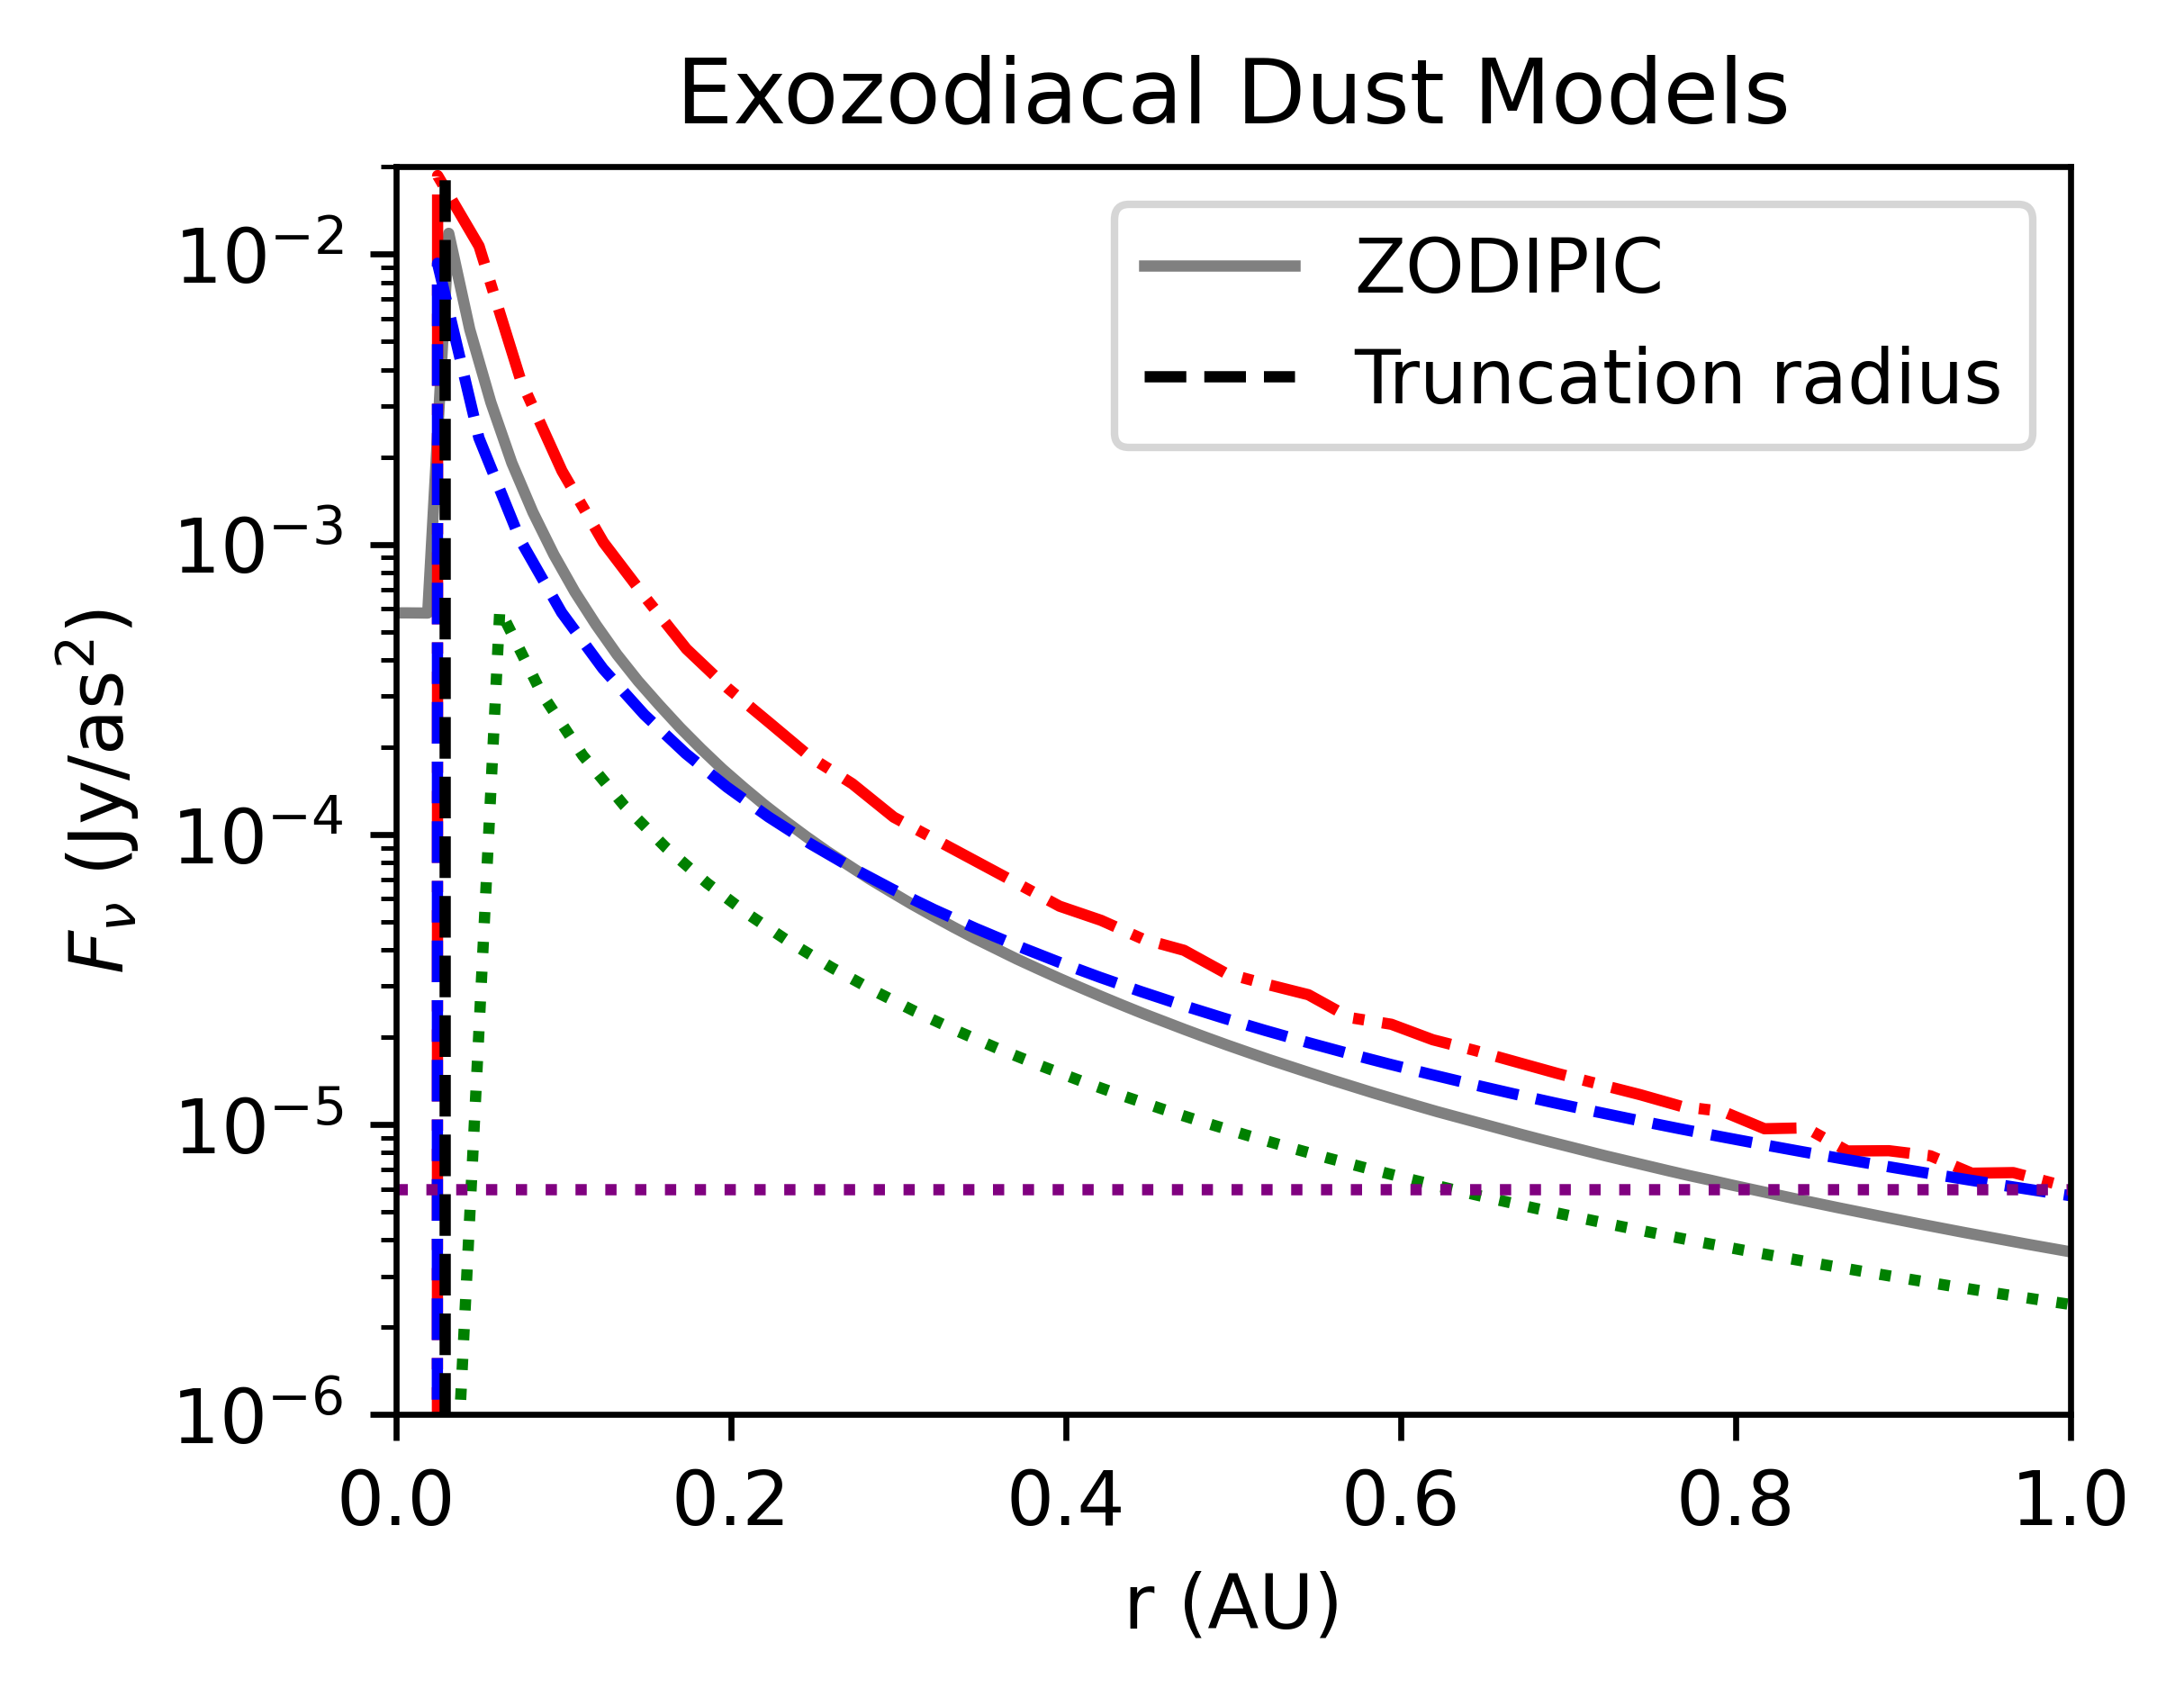

In [32]:
# Define the image
from turtle import color


fig = plt.figure(figsize=(4, 3), dpi=600)

# MCFOST results comparison with the results from the ZODIPIC model
# ZODIPIC
x1 = np.linspace(-view_in_AU/2,view_in_AU/2,896)
#plt.plot(x1,(1000/1.2547439995901082)**2*sav_data['inu'][448], label='ZODIPIC', color='gray')
plt.plot(x1,(1000/1.2547439995901082)**2*sav_data['inu'][448], color='gray')
# MCFOST
x2 = np.linspace(-view_in_AU/2,view_in_AU/2,455)
#plt.plot(x2,F_v.astype(np.float64)[227], label='MCFOST', linestyle='-.', color='red')
plt.plot(x2,F_v.astype(np.float64)[227], linestyle='-.', color='red')

# Exosims
#np.save('exosims_disk_model.npy', np.array([np.arange(-pixel_number//2+1, pixel_number//2+1, 1)*pixel_scale*1000, exosims_disk_model[pixel_number//2, :]]))
exosims = np.load('Toy_Coronagraph/tests/exosims0.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x3 = exosims[0]/1000*10
#plt.plot(x3, exosims[1], label='Exosims', linestyle='--', color='blue')
plt.plot(x3, exosims[1], linestyle='--', color='blue')

# ExoVista
exovista = np.load('Toy_Coronagraph/tests/exovista0.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x4 = exovista[0]/1000*10
#plt.plot(x4, exovista[1], label='ExoVista', linestyle=':', color='green')
plt.plot(x4, exovista[1], linestyle=':', color='green')

# Uniform disk
# 1 zodi = 22 mag/as^2 in V band
# 22 mag/as^2 in V band is 5.99e-6 Jy/as^2 (Johnson UBVRI+)
#plt.axhline(y=5.99e-6, color='purple', linestyle=':', label=r'22 mag/as$^2$')
plt.axhline(y=5.99e-6, color='purple', linestyle=':')

# Add the trumcation radius of the ZODIPIC model
plt.axvline(x=0.0287629, color='black', linestyle='--', label='Truncation radius')

# Add axis units Jy/arcs^2
plt.xlabel('r (AU)')
plt.ylabel(r'$F_{\nu}$ (Jy/as$^2$)')

# Add title 
plt.title('Exozodiacal Dust Models')

# Show the labels
plt.legend()

# log scale
plt.yscale('log')

# Set the limits
plt.xlim(0.0, 1.0)
plt.ylim(1e-6, 0.02)

# Save the plot with dpi 300
fig.savefig('disk_models_in.png', dpi=600)

(896, 896)
0.20498755796282753


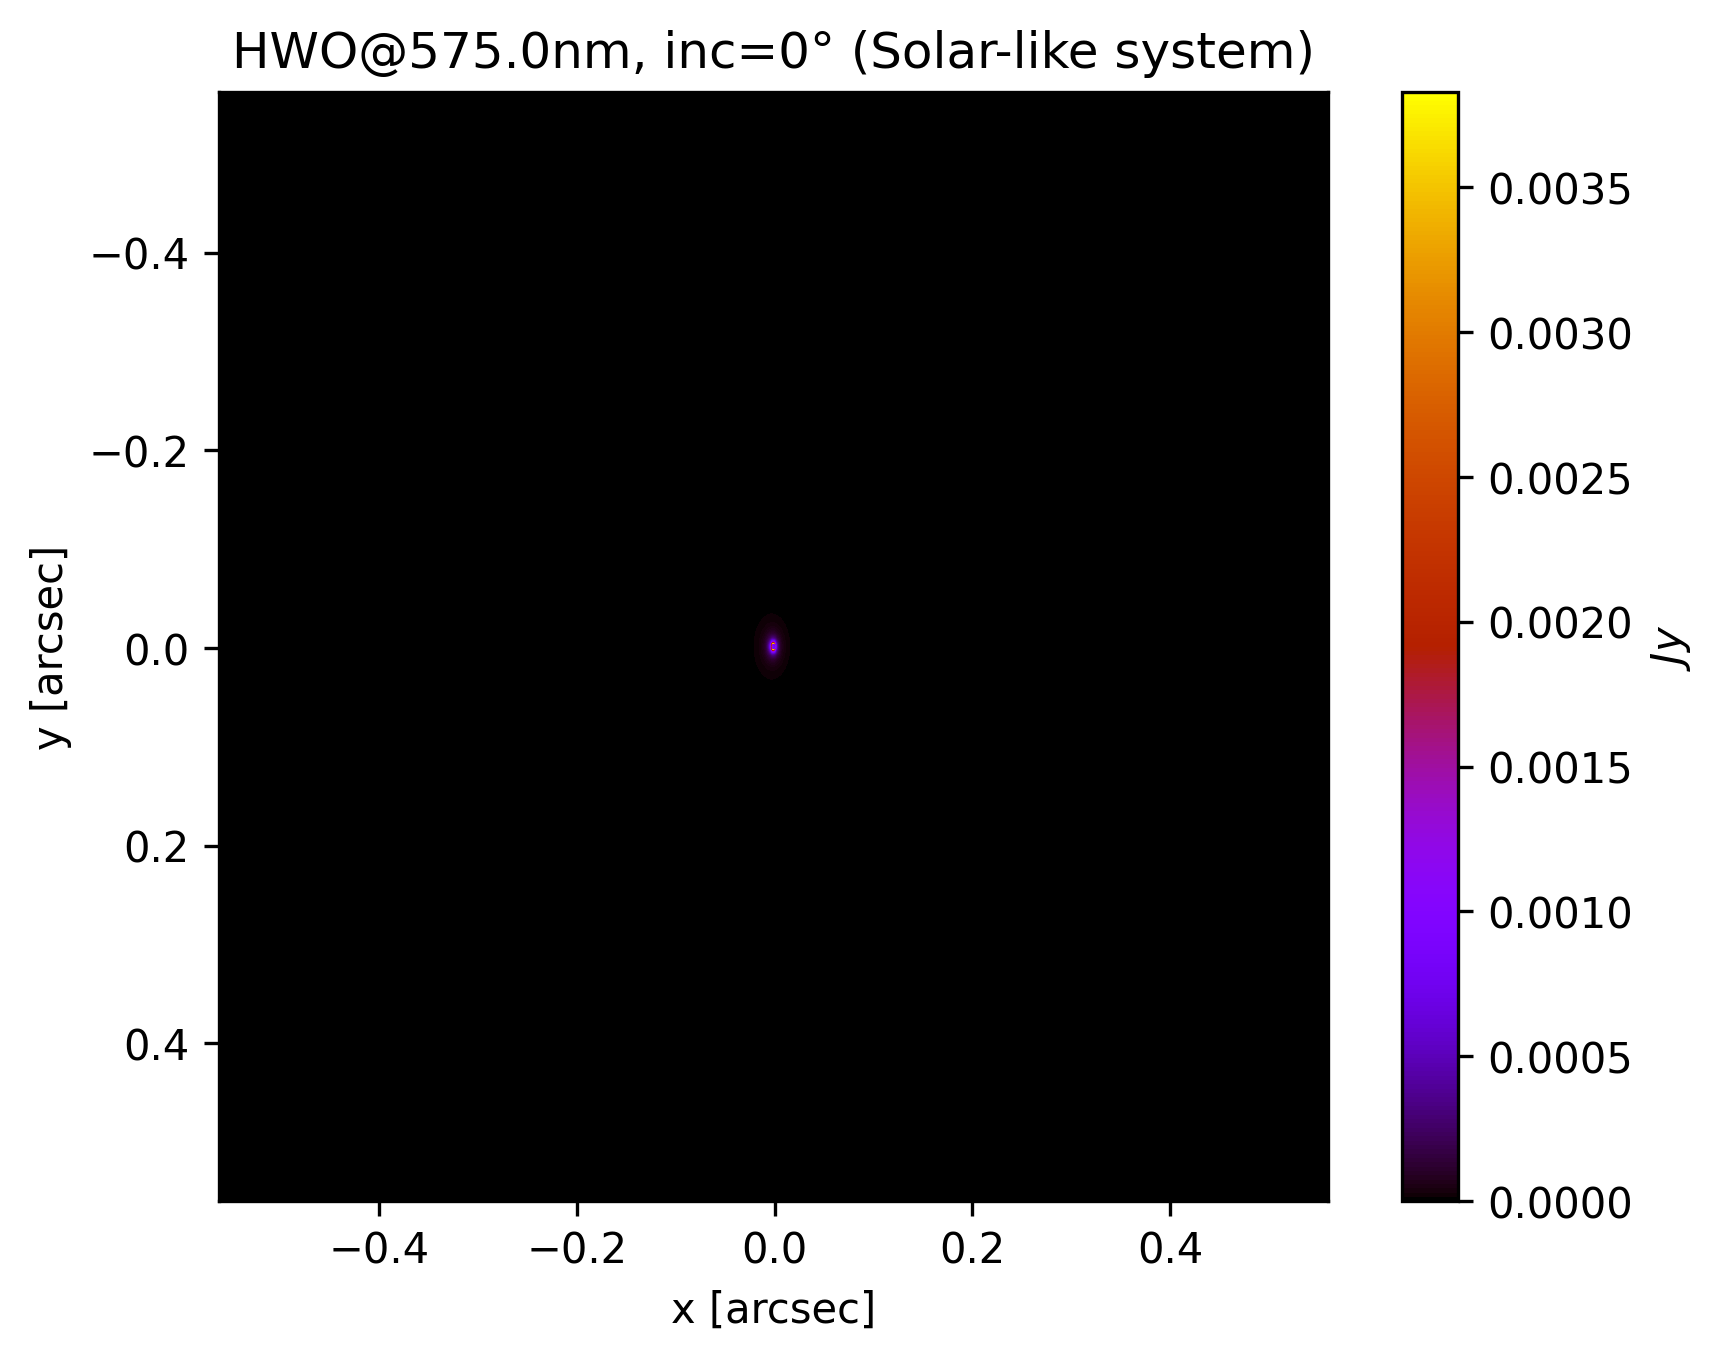

In [25]:
from scipy.io import readsav
sav_data = readsav("1zodi60.sav") # the inner radius truncation is determined by the sublimation, 0.0287629 au
print(np.shape(sav_data['inu']))
#1zodi.sav shows the case with 0.1 au truncation
#1 zodi
#896*896
#1.2547439995901082 mas per pixel
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow((1000/2.887)**2*sav_data['inu'],
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
plt.title("{}@{}nm, inc={}\N{degree sign} (Solar-like system)".format("HWO", wavelength*1e9, inc))
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')
print(np.sum((1000/2.887)**2*sav_data['inu']))

(1e-08, 0.02)

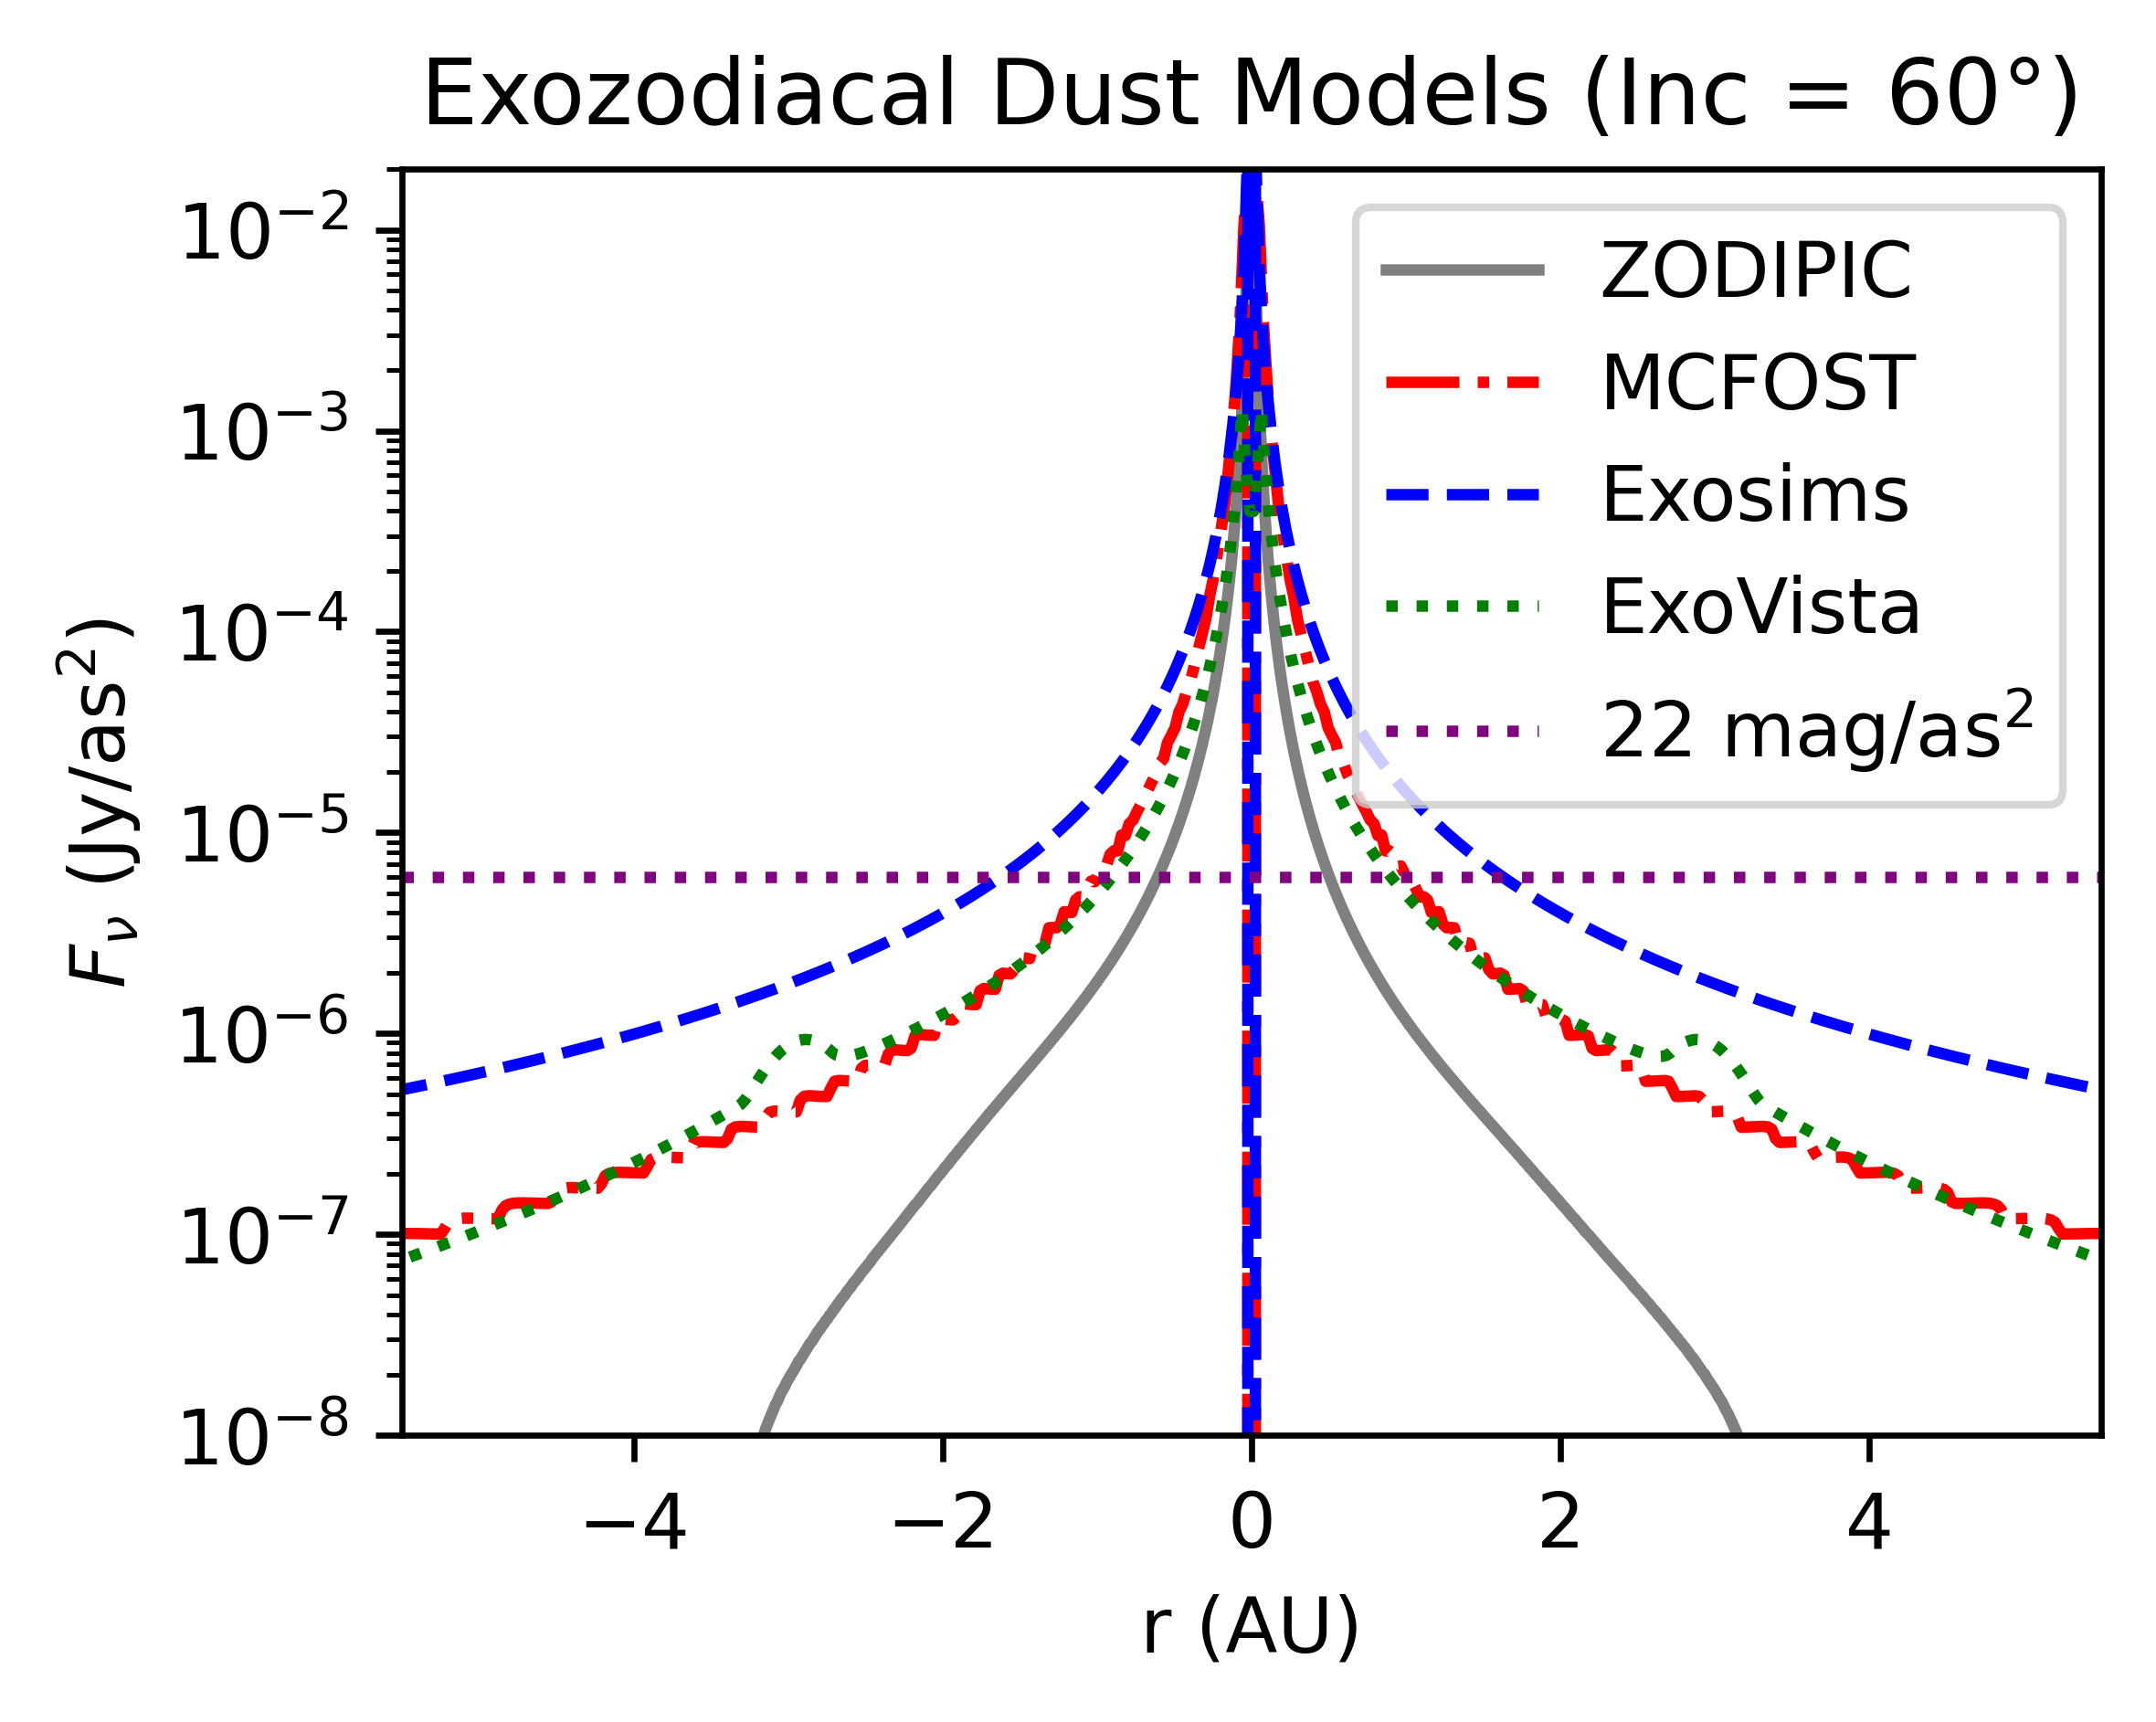

In [26]:
# Define the image
from turtle import color


fig = plt.figure(figsize=(4, 3), dpi=600)

# MCFOST results comparison with the results from the ZODIPIC model
# ZODIPIC
x1 = np.linspace(-view_in_AU/2,view_in_AU/2,896)
sav_data = readsav("1zodi60.sav") # the inner radius truncation is determined by the sublimation, 0.0287629 au
plt.plot(x1,(1000/1.2547439995901082)**2*sav_data['inu'][896//2], label='ZODIPIC', color='gray')

# MCFOST
x2 = np.linspace(-view_in_AU/2,view_in_AU/2,455)
plt.plot(x2,F_v.astype(np.float64)[227], label='MCFOST', linestyle='-.', color='red')

# Exosims
#np.save('exosims_disk_model.npy', np.array([np.arange(-pixel_number//2+1, pixel_number//2+1, 1)*pixel_scale*1000, exosims_disk_model[pixel_number//2, :]]))
exosims = np.load('Toy_Coronagraph/tests/exosims60.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x3 = exosims[0]/1000*10
plt.plot(x3, exosims[1], label='Exosims', linestyle='--', color='blue')

# ExoVista
exovista = np.load('Toy_Coronagraph/tests/exovista60.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x4 = exovista[0]/1000*10
plt.plot(x4, exovista[1], label='ExoVista', linestyle=':', color='green')

# Uniform disk
# 1 zodi = 22 mag/as^2 in V band
# 22 mag/as^2 in V band is 5.99e-6 Jy/as^2 (Johnson UBVRI+)
plt.axhline(y=5.99e-6, color='purple', linestyle=':', label=r'22 mag/as$^2$')

# Add axis units Jy/arcs^2
plt.xlabel('r (AU)')
plt.ylabel(r'$F_{\nu}$ (Jy/as$^2$)')

# Add title 
plt.title('Exozodiacal Dust Models (Inc = 60\N{degree sign})')

# Show the labels
plt.legend()

# log scale
plt.yscale('log')

# Set the limits
plt.xlim(-5.5, 5.5)
plt.ylim(1e-8, 0.02)

# Save the plot with dpi 300
#fig.savefig('disk_models.png', dpi=600)

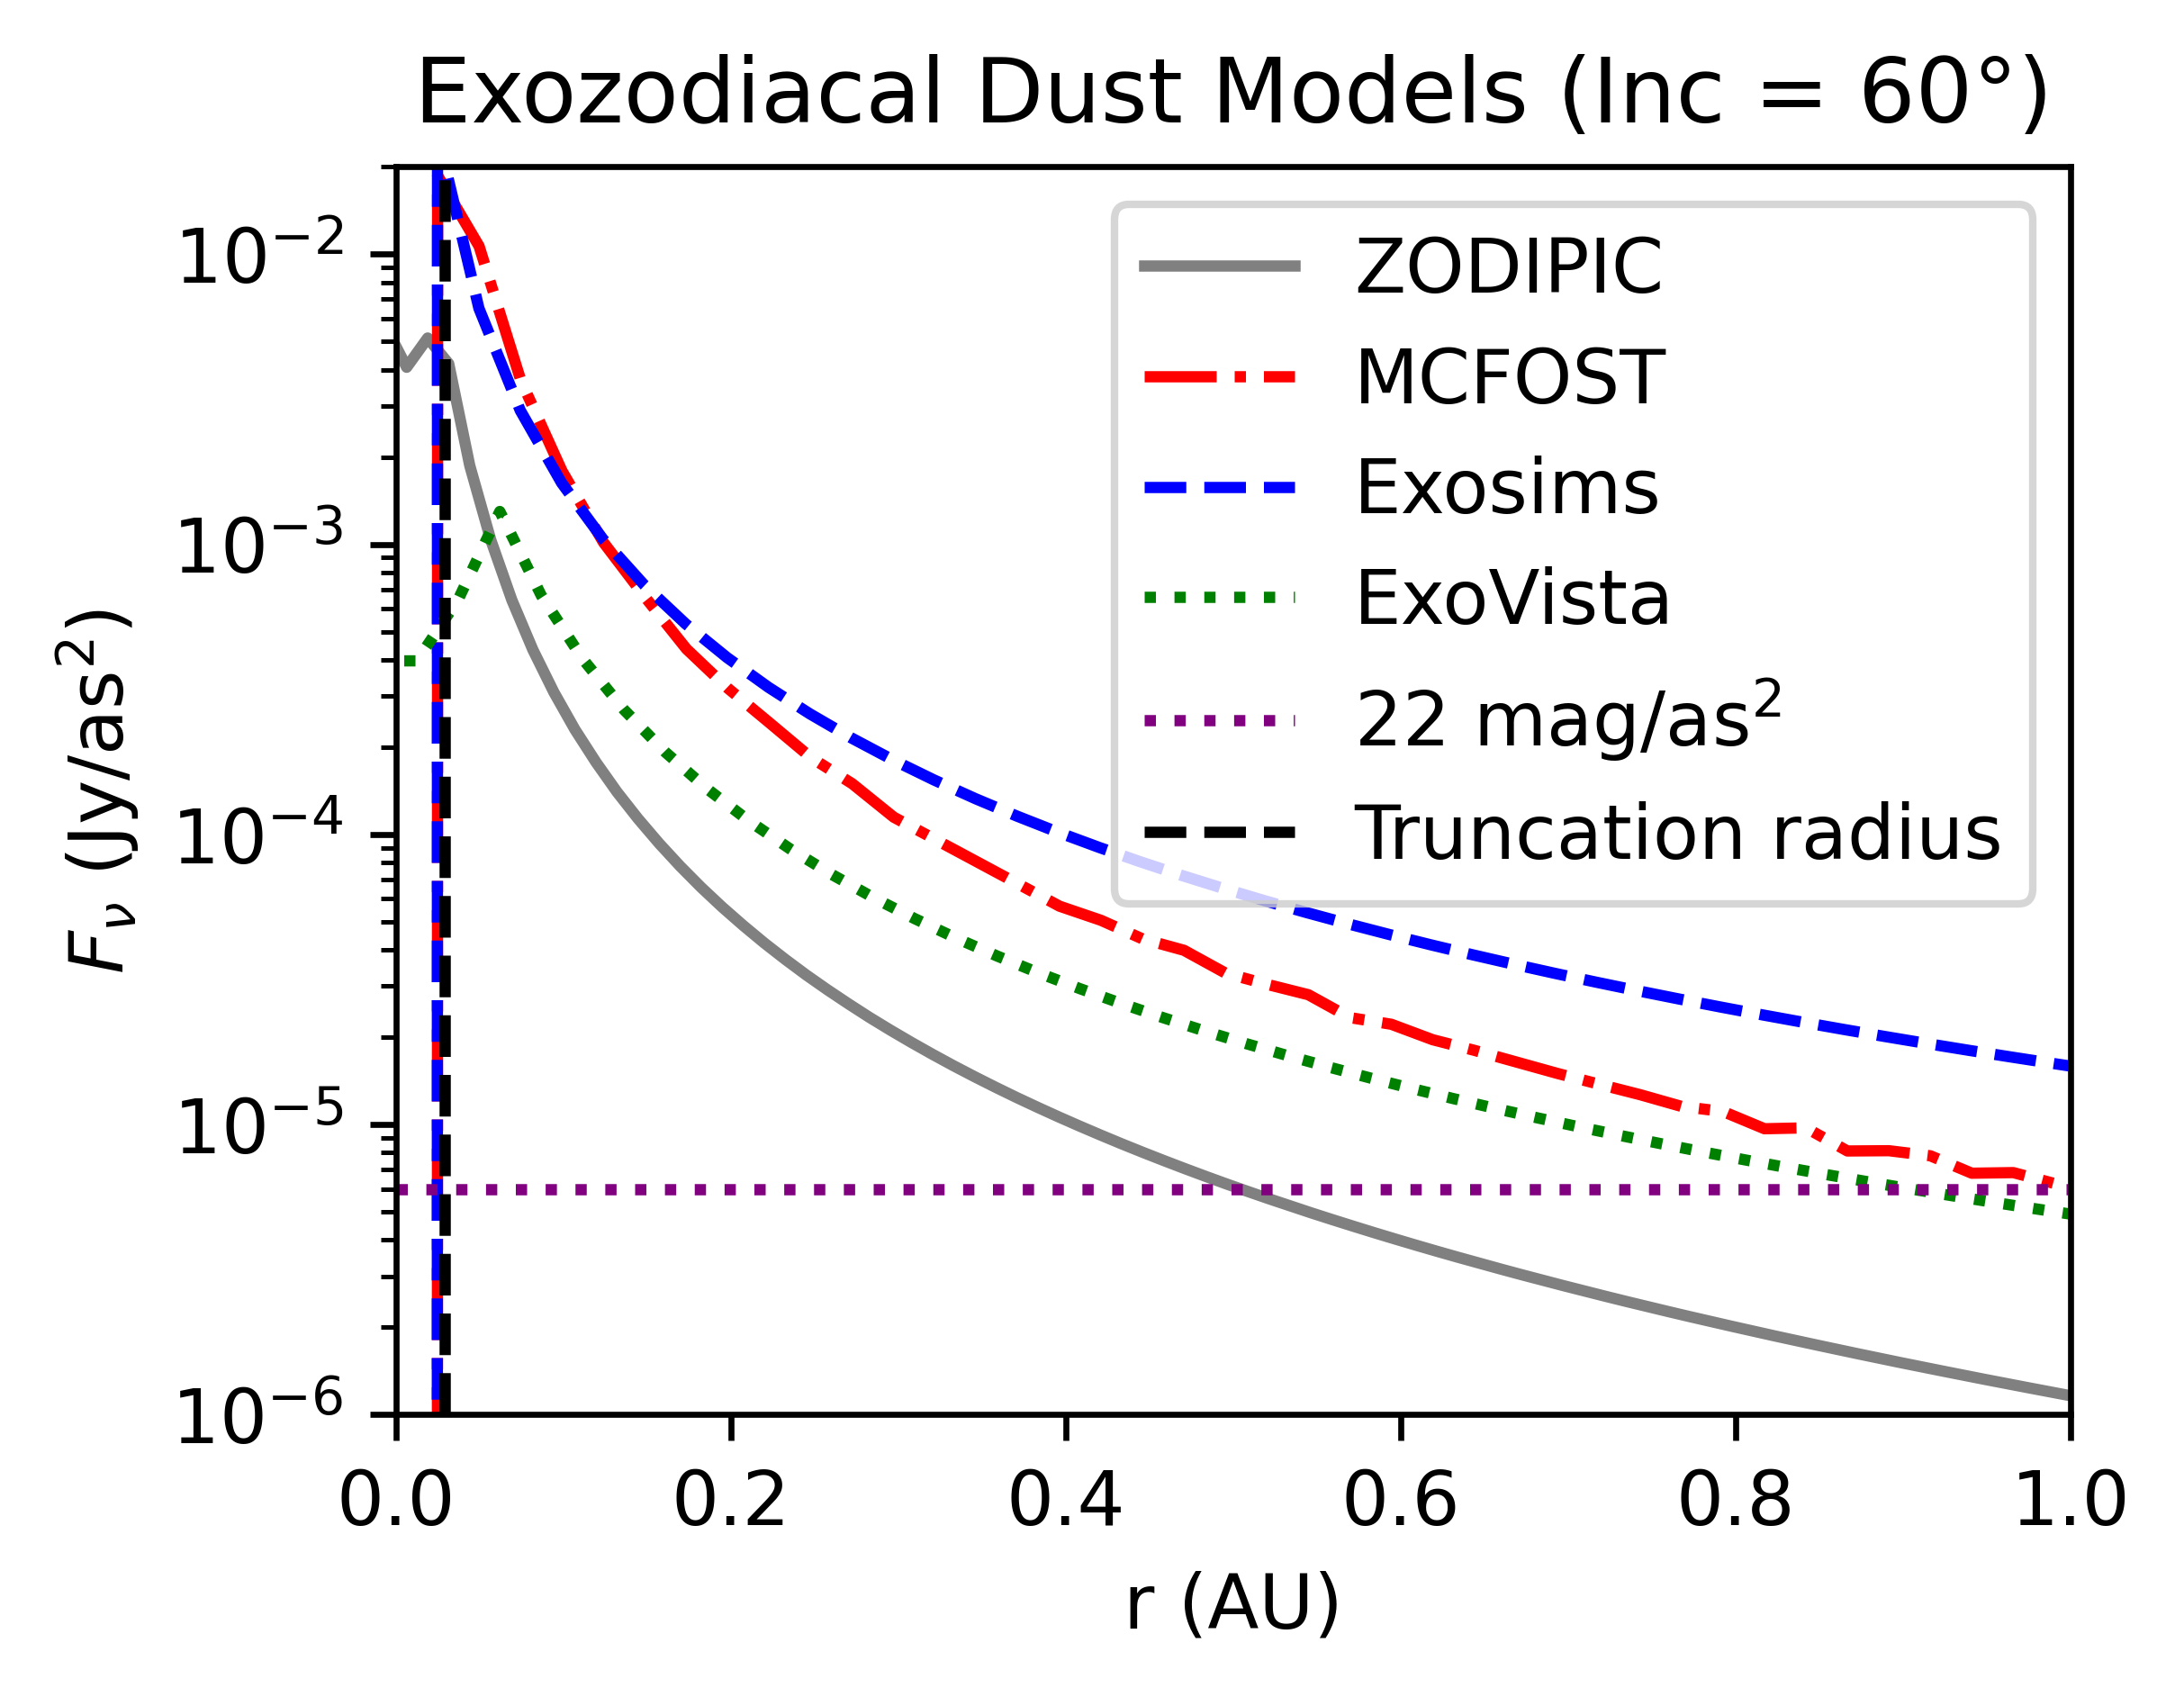

In [27]:
# Define the image
from turtle import color


fig = plt.figure(figsize=(4, 3), dpi=600)

# MCFOST results comparison with the results from the ZODIPIC model
# ZODIPIC
x1 = np.linspace(-view_in_AU/2,view_in_AU/2,896)
sav_data = readsav("1zodi60.sav") # the inner radius truncation is determined by the sublimation, 0.0287629 au
plt.plot(x1,(1000/1.2547439995901082)**2*sav_data['inu'][448], label='ZODIPIC', color='gray')

# MCFOST
x2 = np.linspace(-view_in_AU/2,view_in_AU/2,455)
plt.plot(x2,F_v.astype(np.float64)[227], label='MCFOST', linestyle='-.', color='red')

# Exosims
#np.save('exosims_disk_model.npy', np.array([np.arange(-pixel_number//2+1, pixel_number//2+1, 1)*pixel_scale*1000, exosims_disk_model[pixel_number//2, :]]))
exosims = np.load('Toy_Coronagraph/tests/exosims60.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x3 = exosims[0]/1000*10
plt.plot(x3, exosims[1], label='Exosims', linestyle='--', color='blue')

# ExoVista
exovista = np.load('Toy_Coronagraph/tests/exovista60.npy')
# Read and convert the x from miliarcsec to AU, the system distance is 10 pc
x4 = exovista[0]/1000*10
plt.plot(x4, exovista[1], label='ExoVista', linestyle=':', color='green')

# Uniform disk
# 1 zodi = 22 mag/as^2 in V band
# 22 mag/as^2 in V band is 5.99e-6 Jy/as^2 (Johnson UBVRI+)
plt.axhline(y=5.99e-6, color='purple', linestyle=':', label=r'22 mag/as$^2$')

# Add the trumcation radius of the ZODIPIC model
plt.axvline(x=0.0287629, color='black', linestyle='--', label='Truncation radius')

# Add axis units Jy/arcs^2
plt.xlabel('r (AU)')
plt.ylabel(r'$F_{\nu}$ (Jy/as$^2$)')

# Add title 
plt.title('Exozodiacal Dust Models (Inc = 60\N{degree sign})')

# Show the labels
plt.legend()

# log scale
plt.yscale('log')

# Set the limits
plt.xlim(0.0, 1.0)
plt.ylim(1e-6, 0.02)

# Save the plot with dpi 300
fig.savefig('disk_models_in.png', dpi=600)

(896, 896)
0.20498755796282753


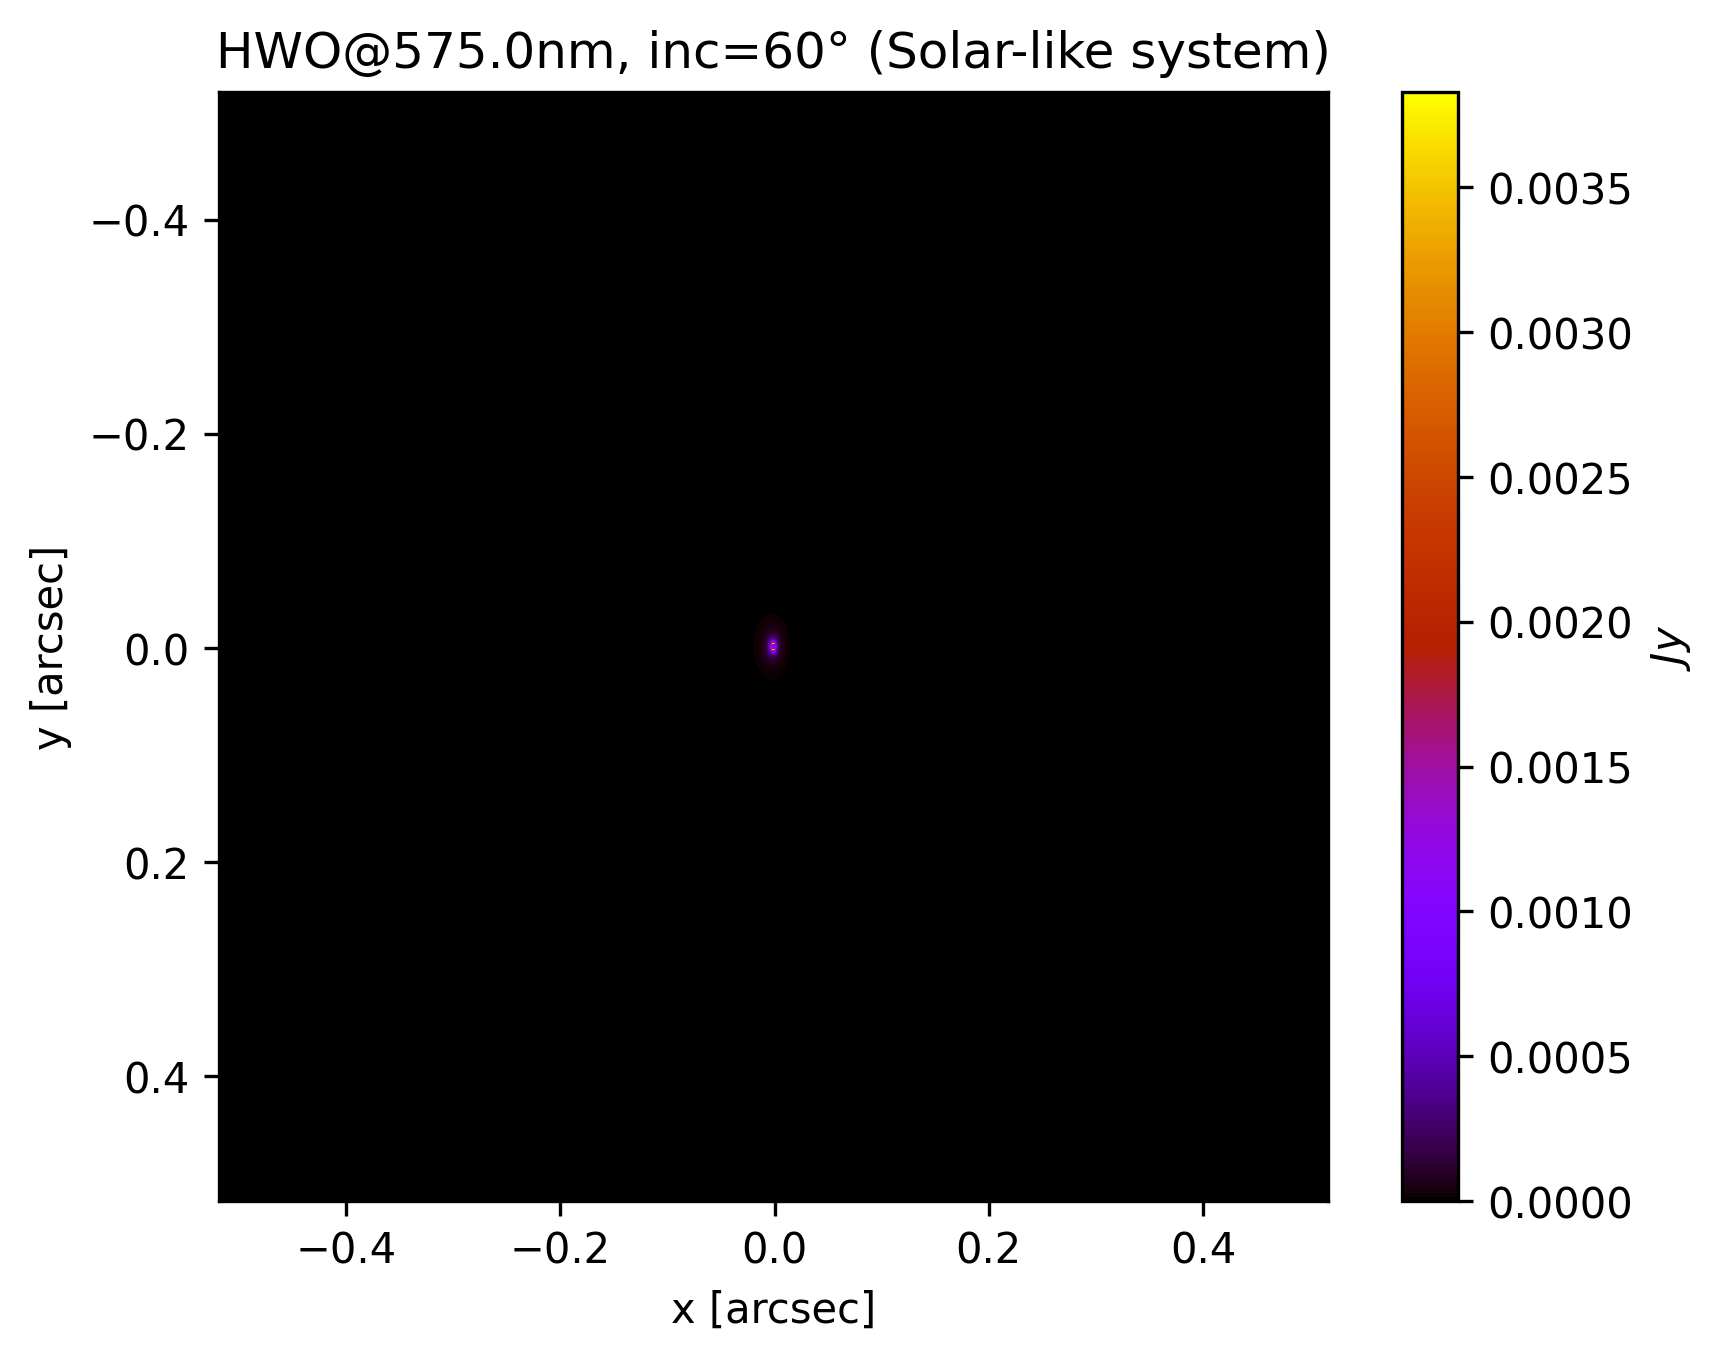

In [37]:
from scipy.io import readsav
inc = 60
sav_data = readsav("1zodi60.sav") # the inner radius truncation is determined by the sublimation, 0.0287629 au
print(np.shape(sav_data['inu']))
#1zodi.sav shows the case with 0.1 au truncation
#1 zodi
#896*896
#1.2547439995901082 mas per pixel
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow((1000/2.887)**2*sav_data['inu'],
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
plt.title("{}@{}nm, inc={}\N{degree sign} (Solar-like system)".format("HWO", wavelength*1e9, inc))
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')
print(np.sum((1000/2.887)**2*sav_data['inu']))

In [ ]:
# Define the image
fig = plt.figure(figsize=(6, 4))

# MCFOST results comparison with the results from the ZODIPIC model
# ZODIPIC
x1 = np.linspace(-view_in_AU/2,view_in_AU/2,448)
plt.plot(x1,(1000/2.887)**2*sav_data['inu'][224], label='ZODIPIC')

# MCFOST
x2 = np.linspace(-view_in_AU/2,view_in_AU/2,455)
plt.plot(x2,F_v.astype(np.float64)[227], label='MFOST', linestyle=':')

# Add axis units Jy/arcs^2
plt.xlabel('r (AU)')
plt.ylabel(r'$F_{\nu}$ (Jy/arcsec$^2$)')

# Add title 
plt.title('MCFOST and ZODIPIC comparison')

# Show the labels
plt.legend()

# log scale
plt.yscale('log')

# Save the plot with dpi 300
fig.savefig('zodipic_vs_mcfost.png', dpi=300)

(array([], dtype=int64),)


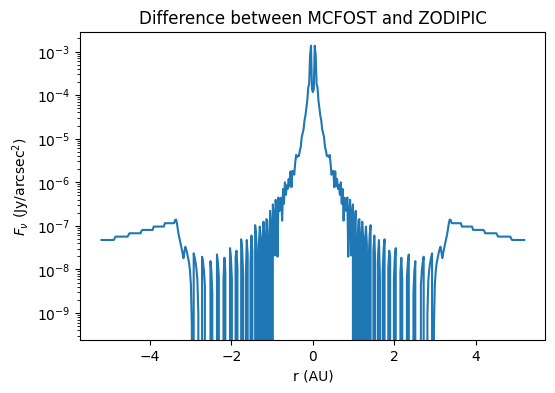

In [20]:
from scipy.interpolate import interp1d
# Build a interprolation function for ZODIPIC model
f = interp1d(x1, (1000/2.887)**2*sav_data['inu'][224], kind='cubic')
# Plot the difference between the two models
fig = plt.figure(figsize=(6, 4))
plt.plot(x2, F_v.astype(np.float64)[227]-f(x2))
plt.xlabel('r (AU)')
plt.ylabel(r'$F_{\nu}$ (Jy/arcsec$^2$)')
plt.title('Difference between MCFOST and ZODIPIC')
# log scale
plt.yscale('log')
fig.savefig('difference.png', dpi=300)

In [12]:
!set NUMEXPR_MAX_THREADS = 64
from hcipy import *
#import numpy as np
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#mpl.rcParams['figure.dpi'] = 100

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

charge = 6
pupil_grid = make_pupil_grid(1024, 1.5)
focal_grid = make_focal_grid(16, 16)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = evaluate_supersampled(make_circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(make_circular_aperture(0.5), pupil_grid, 4)
coro = VortexCoronagraph(pupil_grid, charge)
lyot_stop = Apodizer(lyot_mask)

numexpr.utils: INFO     Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils: INFO     NumExpr defaulting to 8 threads.


In [13]:
import numpy as np
import multiprocessing as mp
!set NUMEXPR_MAX_THREADS = 64
from hcipy import *
#import numpy as np
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#mpl.rcParams['figure.dpi'] = 100

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

charge = 10
pupil_grid = make_pupil_grid(1024, 1.5)
focal_grid = make_focal_grid(16, 16)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = evaluate_supersampled(make_circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(make_circular_aperture(0.5), pupil_grid, 4)
coro = VortexCoronagraph(pupil_grid, charge)
lyot_stop = Apodizer(lyot_mask)

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

def psf_chunk(i, img_pixel, psf_range):
    x = 2*i*psf_range / img_pixel
    wf = Wavefront(Wavefront_pos(x, 0))
    img = prop(lyot_stop(coro(wf))).intensity
    return i, img.to_dict()["values"].reshape(img_pixel, img_pixel)

def psf_calculation(img_pixel, psf_range):
    num_cores = 4
    chunk_size = img_pixel // (2*num_cores)
    psfs = np.empty((img_pixel//2+1, img_pixel, img_pixel))
    
    pool = mp.Pool(processes=num_cores)
    results = [pool.apply_async(psf_chunk, args=(i, img_pixel, psf_range)) for i in range(img_pixel//2+1)]
    pool.close()
    pool.join()
    for result in results:
        i, psf = result.get()
        psfs[i] = psf
    return psfs

img_pixel = 512
psf_range = 16
psfs = psf_calculation(img_pixel, psf_range)
np.save('psfs_c'+str(charge)+'.npy', psfs)

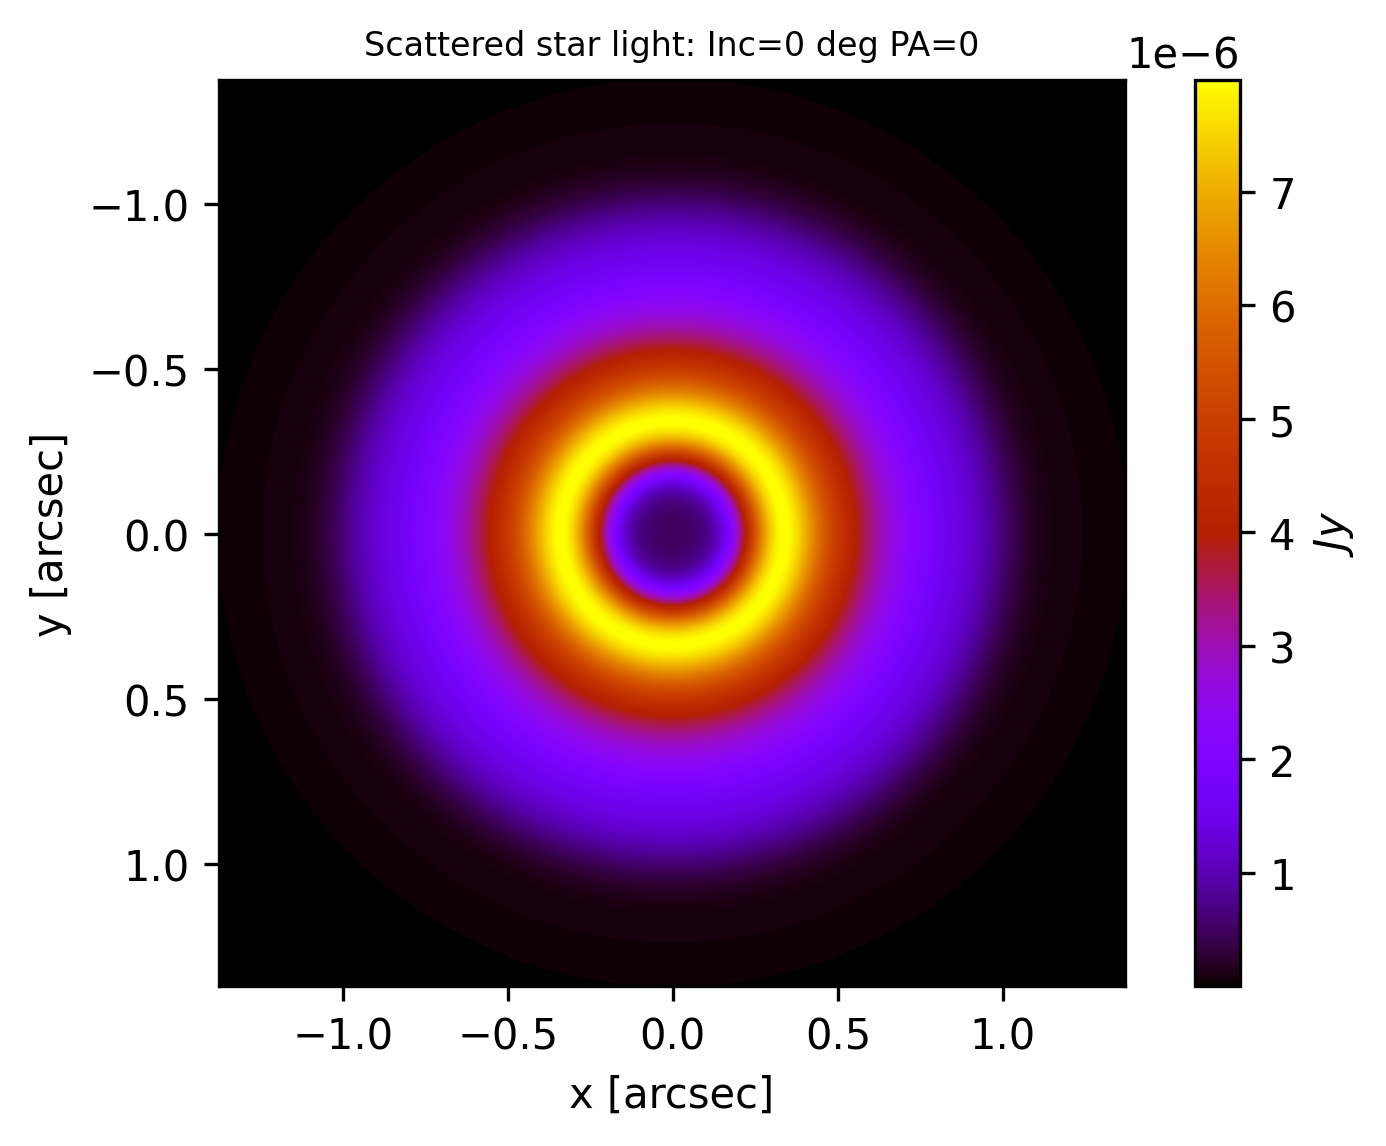

In [19]:
import numpy as np
import multiprocessing as mp
from skimage.transform import rotate

def cir_psf(pre_img, img_pixel, psf_range, rot_number, psfs_name=None):
    chunk_img = np.zeros([img_pixel, img_pixel])
    if psfs_name==None:
        for i in range(img_pixel//2+1):
            x = 2*i*psf_range / img_pixel
            weight = pre_img[255+i][255]
            if weight != 0:
                wf = Wavefront(Wavefront_pos(x, 0))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += 2*np.pi*i*weight*img.to_dict()["values"].reshape(img_pixel, img_pixel)/rot_number
    else:
        psfs = np.load(psfs_name)
        for i in range(img_pixel//2+1):
            weight = pre_img[255+i][255]
            if weight != 0:
                chunk_img += 2*np.pi*i*weight*psfs[i]/rot_number
    final_img = np.zeros([img_pixel, img_pixel])
    for i in range(rot_number):
        final_img += rotate(chunk_img, angle=360*i/rot_number)
    return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16
rot_number = 360


final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel, 'psfs_c10.npy')
#final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel)

#plot
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge6,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [64]:
import numpy as np
import multiprocessing as mp
from skimage.transform import rotate

def cir_psf(pre_img, img_pixel, psf_range, rot_number, psfs_name=None):
    chunk_img = np.zeros([img_pixel, img_pixel])
    if psfs_name==None:
        for i in range(img_pixel//2+1):
            x = 2*i*psf_range / img_pixel
            weight = pre_img[255+i][255]
            if weight != 0:
                wf = Wavefront(Wavefront_pos(x, 0))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += 2*np.pi*i*weight*img.to_dict()["values"].reshape(img_pixel, img_pixel)/rot_number
    else:
        psfs = np.load(psfs_name)
        for i in range(img_pixel//2+1):
            weight = pre_img[255+i][255]
            if weight != 0:
                chunk_img += 2*np.pi*i*weight*psfs[i]/rot_number
    final_img = np.zeros([img_pixel, img_pixel])
    for i in range(rot_number):
        final_img += rotate(chunk_img, angle=360*i/rot_number)
    return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16
rot_number = 360


#final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel, 'psfs_c6.npy')
final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel)

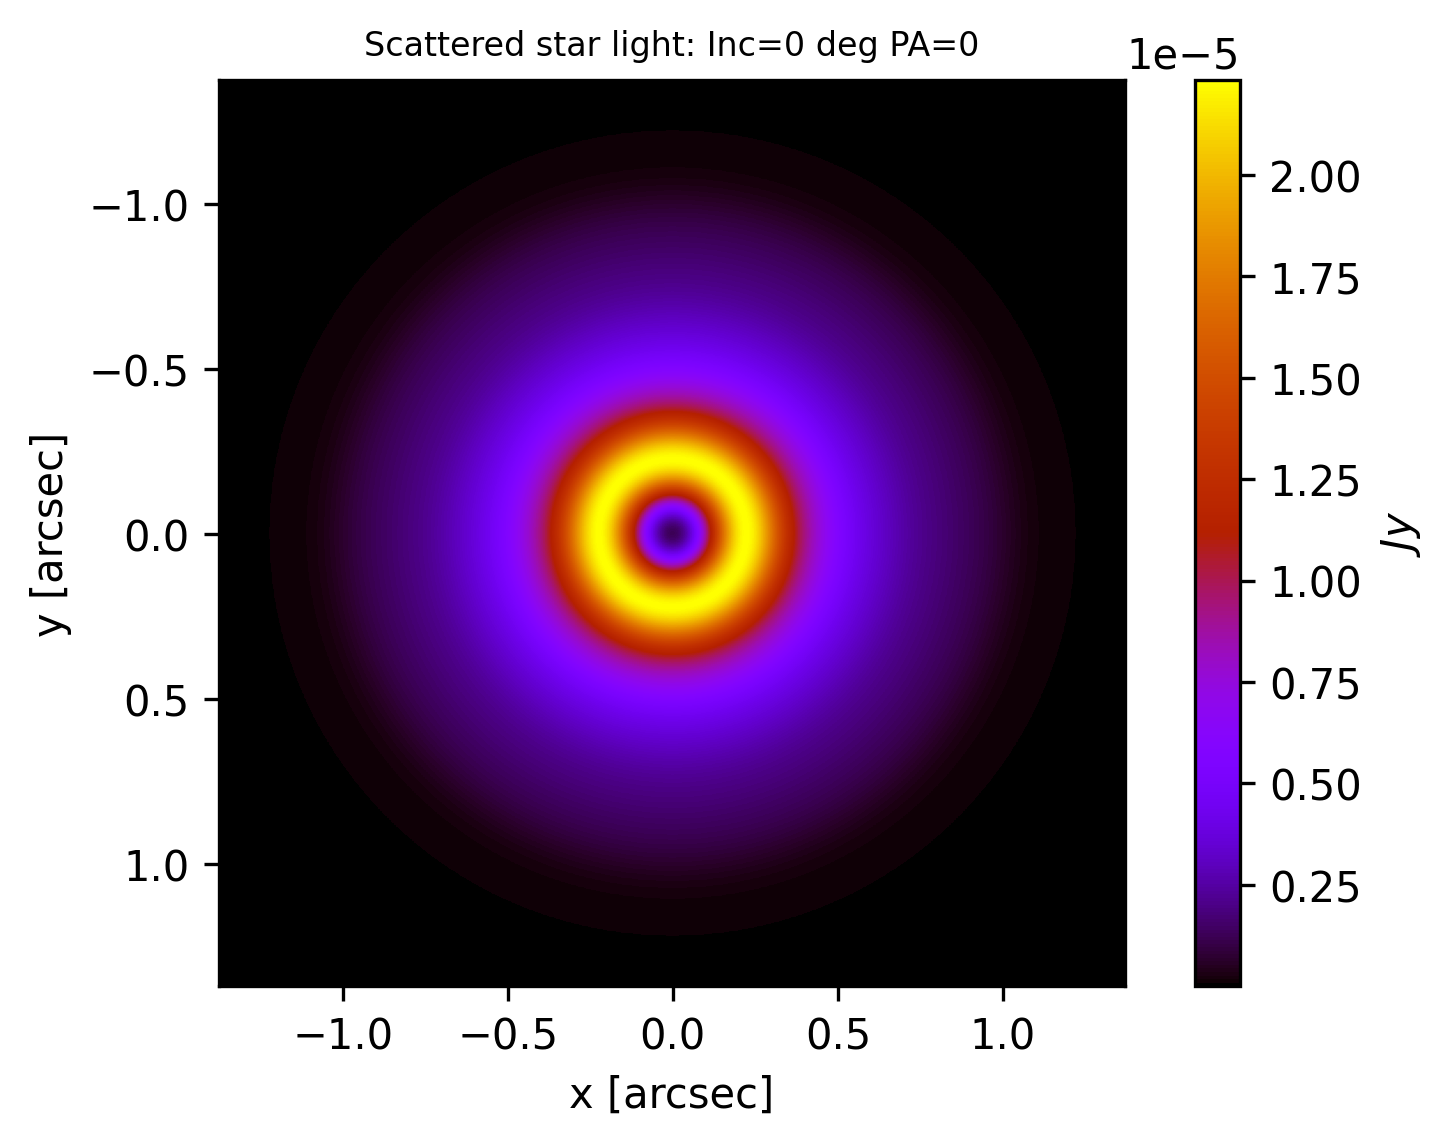

In [65]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge6,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [ ]:
import numpy as np
import multiprocessing as mp
'''
x>=y>=0
256>=x>=0

1.  x, y
2.  y ,x
3. -y, x
4. -x, y
5. -x,-y
6. -y,-x
7.  y,-x
8.  x,-y
'''

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

def psf_chunk(i, psfs, img_pixel, psf_range):
    print(i)
    x = 2*i*psf_range / img_pixel
    for j in range(i):
        y = 2*j*psf_range / img_pixel
        wf = Wavefront(Wavefront_pos(x, y))
        img = prop(lyot_stop(coro(wf))).intensity
        psf = img.to_dict()["values"].reshape(img_pixel, img_pixel)
        psfs[i][j] = psf
        psfs[j][i] = np.transpose(psf[::-1, ::-1])
    wf = Wavefront(Wavefront_pos(x, x))
    img = prop(lyot_stop(coro(wf))).intensity
    psfs[i][i] = img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return i

def psf_calculation(img_pixel, psf_range):
    psfs = np.empty((img_pixel//2 + 1, img_pixel//2 + 1, img_pixel, img_pixel))
    check_points = [psf_chunk(i, psfs, img_pixel, psf_range) for i in range(img_pixel//2 + 1)]
    np.save('psfs.npy', psfs)
    return 0

img_pixel = 512
psf_range = 16
psf_calculation(img_pixel, psf_range)

In [15]:
import numpy as np
import multiprocessing as mp

def calculate_chunk(chunk_range, pre_img, img_pixel, psf_range):
    chunk_img = np.zeros([img_pixel, img_pixel])
    for i in chunk_range:
        x = (2 * i + 2 - img_pixel) * psf_range / img_pixel
        for j in range(img_pixel):
            weight = pre_img[i][j]
            if weight != 0:
                y = (2 * j + 2 - img_pixel) * psf_range / img_pixel
                wf = Wavefront(Wavefront_pos(x, y))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += weight * img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return chunk_img

def parallel_calculation(pre_img, img_pixel, psf_range):
    num_cores = 64
    chunk_size = img_pixel // num_cores

    pool = mp.Pool(processes=num_cores)
    chunk_ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(num_cores)]
    results = [pool.apply_async(calculate_chunk, args=(chunk_range, pre_img, img_pixel, psf_range)) for chunk_range in chunk_ranges]
    pool.close()
    pool.join()

    #
    return results
    #return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16

results = parallel_calculation(pre_img, img_pixel, psf_range)
chunk_results = [result.get() for result in results]
final_img_charge2 = np.sum(chunk_results, axis=0)

In [17]:
import numpy as np
import multiprocessing as mp

def calculate_chunk(chunk_range, pre_img, img_pixel, psf_range):
    chunk_img = np.zeros([img_pixel, img_pixel])
    for i in chunk_range:
        x = (2 * i + 2 - img_pixel) * psf_range / img_pixel
        for j in range(img_pixel):
            weight = pre_img[i][j]
            if weight != 0:
                y = (2 * j + 2 - img_pixel) * psf_range / img_pixel
                wf = Wavefront(Wavefront_pos(x, y))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += weight * img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return chunk_img

def parallel_calculation(pre_img, img_pixel, psf_range):
    num_cores = 64
    chunk_size = img_pixel // num_cores

    pool = mp.Pool(processes=num_cores)
    chunk_ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(num_cores)]
    results = [pool.apply_async(calculate_chunk, args=(chunk_range, pre_img, img_pixel, psf_range)) for chunk_range in chunk_ranges]
    pool.close()
    pool.join()

    #
    return results
    #return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16

results = parallel_calculation(pre_img, img_pixel, psf_range)
chunk_results = [result.get() for result in results]
final_img_charge4 = np.sum(chunk_results, axis=0)

In [11]:
import numpy as np
import multiprocessing as mp

def calculate_chunk(chunk_range, pre_img, img_pixel, psf_range):
    chunk_img = np.zeros([img_pixel, img_pixel])
    for i in chunk_range:
        x = (2 * i + 2 - img_pixel) * psf_range / img_pixel
        for j in range(img_pixel):
            weight = pre_img[i][j]
            if weight != 0:
                y = (2 * j + 2 - img_pixel) * psf_range / img_pixel
                wf = Wavefront(Wavefront_pos(x, y))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += weight * img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return chunk_img

def parallel_calculation(pre_img, img_pixel, psf_range):
    num_cores = 64
    chunk_size = img_pixel // num_cores

    pool = mp.Pool(processes=num_cores)
    chunk_ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(num_cores)]
    results = [pool.apply_async(calculate_chunk, args=(chunk_range, pre_img, img_pixel, psf_range)) for chunk_range in chunk_ranges]
    #chunk_results = [result.get() for result in results]
    pool.close()
    pool.join()

    #final_img = np.sum(chunk_results, axis=0)
    return results
    #return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16

final_img = parallel_calculation(pre_img, img_pixel, psf_range)
#print(final_img)

In [12]:
chunk_results = [result.get() for result in final_img[:]]
final_img_tmp = np.sum(chunk_results, axis=0)

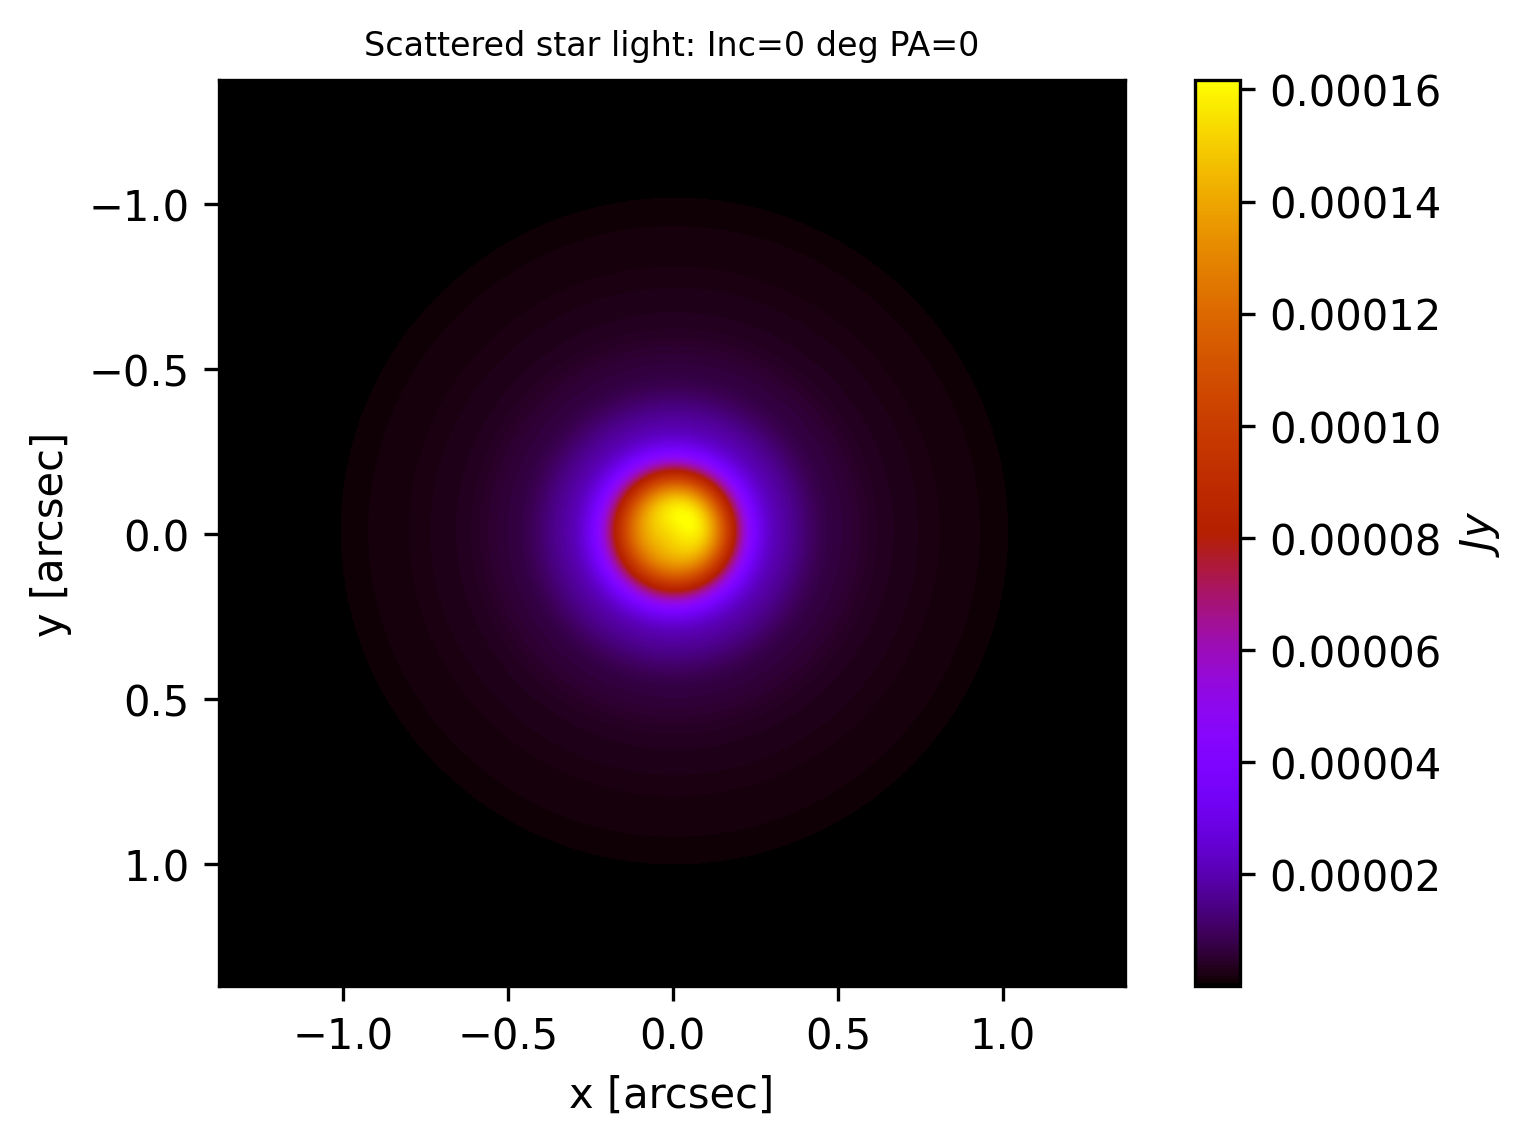

In [16]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge2,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

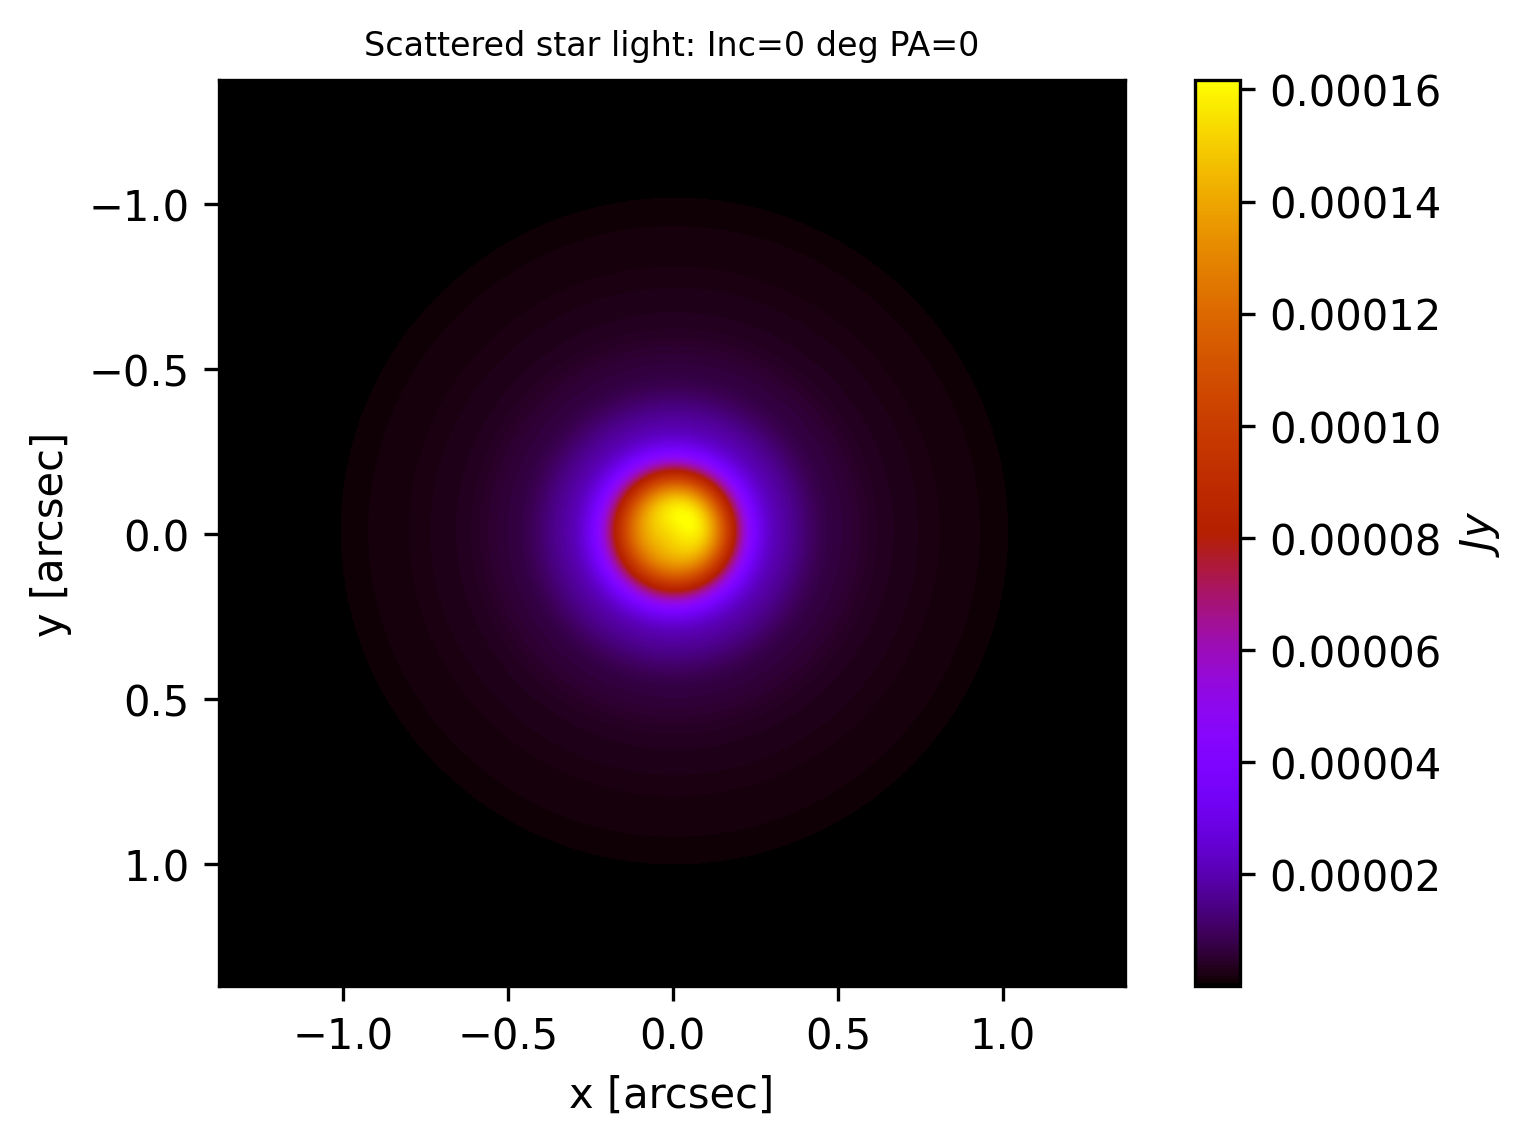

In [18]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge4,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

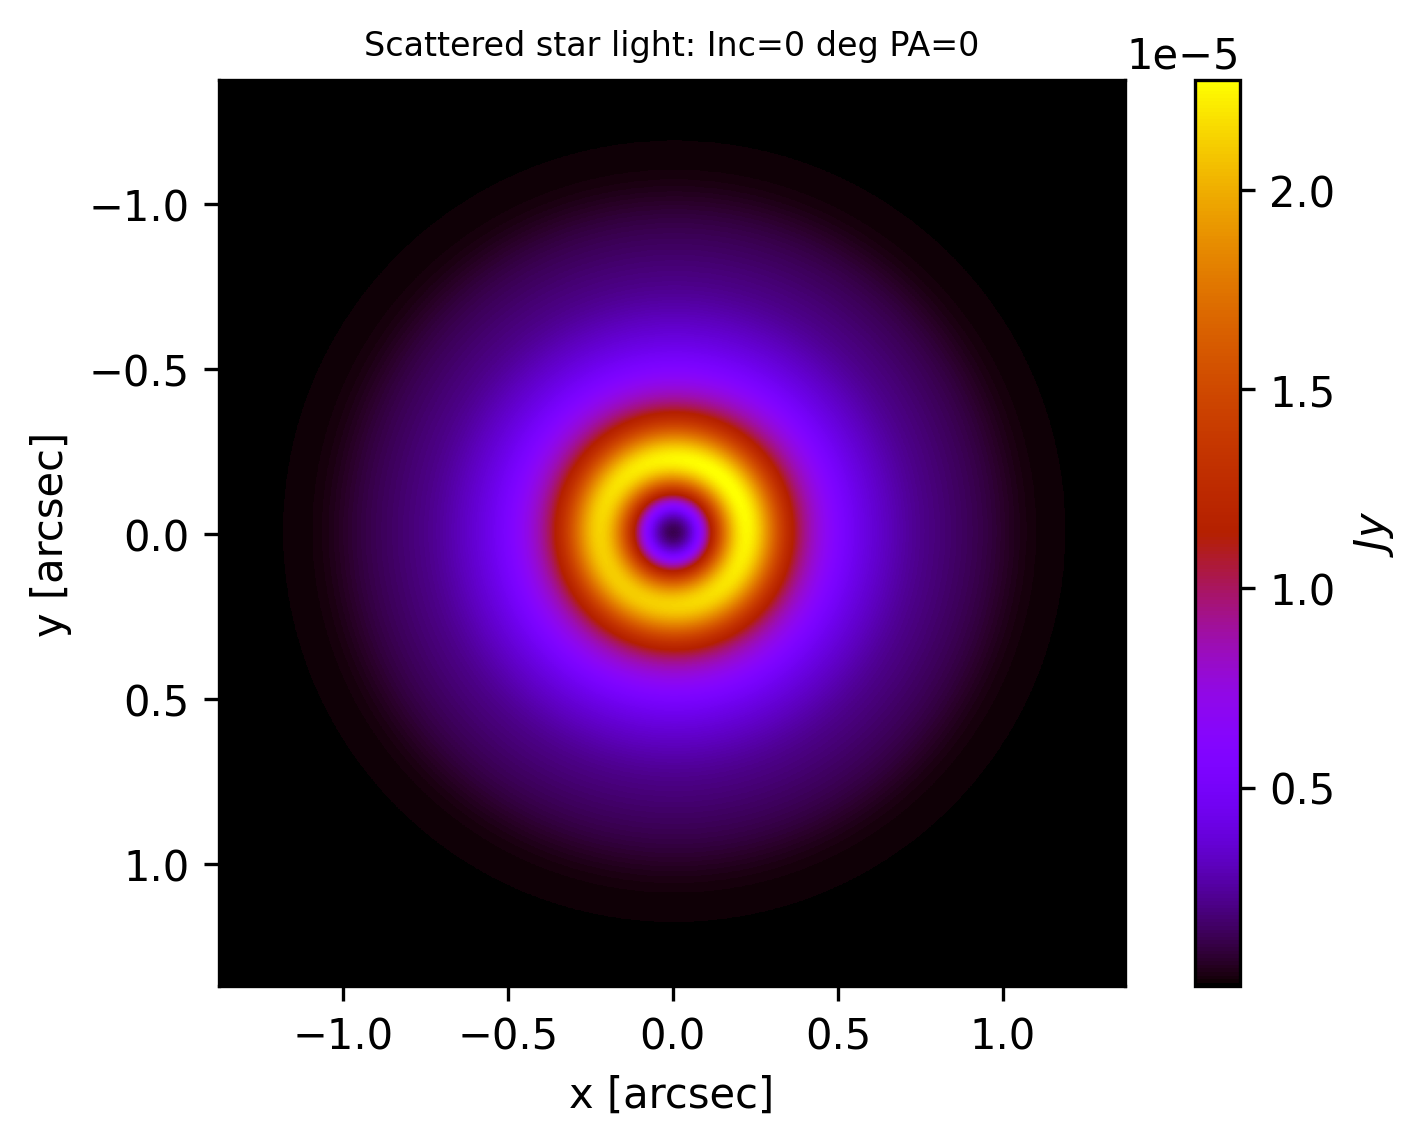

In [13]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_tmp,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [55]:
final_img_tmp

array([[7.95847615e-10, 7.99828221e-10, 8.04630270e-10, ...,
        8.18901137e-10, 8.13905757e-10, 8.09748913e-10],
       [8.00131088e-10, 8.05060462e-10, 8.10828977e-10, ...,
        8.25462842e-10, 8.19549095e-10, 8.14487040e-10],
       [8.05367284e-10, 8.11264956e-10, 8.18001366e-10, ...,
        8.32950255e-10, 8.26123597e-10, 8.20144875e-10],
       ...,
       [8.18177694e-10, 8.25261692e-10, 8.33186186e-10, ...,
        8.48831631e-10, 8.40821159e-10, 8.33657694e-10],
       [8.11742036e-10, 8.17839097e-10, 8.24798560e-10, ...,
        8.40151414e-10, 8.33039880e-10, 8.26799956e-10],
       [8.06291470e-10, 8.11399594e-10, 8.17373282e-10, ...,
        8.32373530e-10, 8.26188301e-10, 8.20882012e-10]])

In [64]:
#lambda/D in arcsec
#2.4m
#1000nm
1e-6/2.4*206264.806*16

1.3750987066666667

In [97]:
sst_jy.astype(np.float64)[511]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
#Polarization of the disk
I=np.reshape(inc.data[0,0],(px,py))
Q=np.reshape(inc.data[1,0],(px,py))
U=np.reshape(inc.data[2,0],(px,py))
V=np.reshape(inc.data[3,0],(px,py))
dst=np.reshape(inc.data[4,0],(px,py))
sst=np.reshape(inc.data[5,0],(px,py))
dth=np.reshape(inc.data[6,0],(px,py))
sth=np.reshape(inc.data[7,0],(px,py))

In [73]:
I_jy=(I/c)*(wave_length**2)*jy
Q_jy=(Q/c)*(wave_length**2)*jy
U_jy=(U/c)*(wave_length**2)*jy
V_jy=(V/c)*(wave_length**2)*jy
sst_jy=(sst/c)*(wave_length**2)*jy

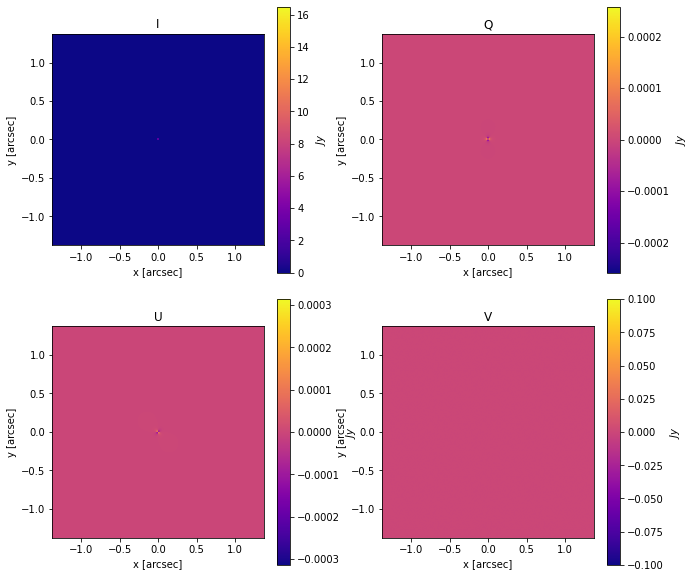

In [74]:
fig = plt.figure(figsize=(10, 10))
ax1=fig.add_subplot(221)
im1=ax1.imshow(I_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title('I')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$Jy$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(Q_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Q')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
ax2.grid(False)

ax3=fig.add_subplot(223)
im3=ax3.imshow(U_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax3.set_ylabel('y [arcsec]')
ax3.set_xlabel('x [arcsec]')
ax3.set_title('U')
cb = fig.colorbar(im3,orientation='vertical')
cb.set_label("$Jy$")
ax3.grid(False)

ax4=fig.add_subplot(224)
im4=ax4.imshow(V_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax4.set_ylabel('y [arcsec]')
ax4.set_xlabel('x [arcsec]')
ax4.set_title('V')
cb = fig.colorbar(im4,orientation='vertical')
cb.set_label("$Jy$")
ax4.grid(False)
fig.subplots_adjust(hspace=0.1, wspace=0.25, top=0.9, right=0.95)

NameError: name 'zo_file' is not defined

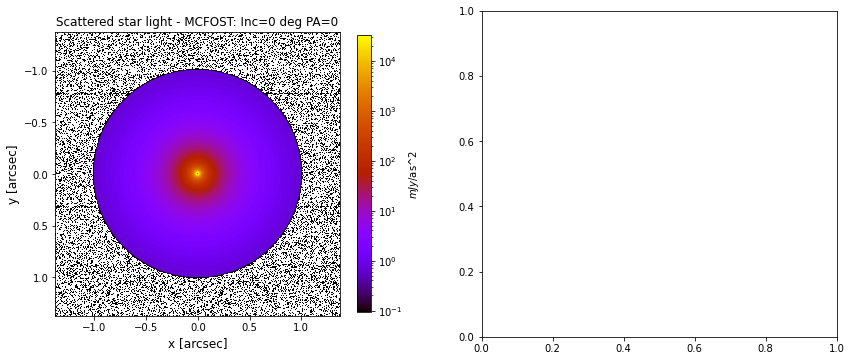

In [75]:
fig=plt.figure(figsize=(14, 6))
ax2=plt.subplot(121)
im2=ax2.imshow(sst_jy.astype(np.float64)/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)],norm=LogNorm())
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]',fontsize=12)
ax2.set_xlabel('x [arcsec]',fontsize=12)
ax2.set_title('Scattered star light - MCFOST: Inc=0 deg PA=0',fontsize=12)
cb=plt.colorbar(im2,orientation='vertical',shrink=0.85)
cb.set_label("$mJy$/as^2")

ax2=plt.subplot(122)
im2=ax2.imshow(zo_file[0].data.astype(np.float64)/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)],norm=LogNorm())
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]',fontsize=12)
ax2.set_xlabel('x [arcsec]',fontsize=12)
ax2.set_title('Scattered star light - Zodipic: Inc=0 deg PA=0',fontsize=12)
cb=plt.colorbar(im2,orientation='vertical', shrink=0.85)
cb.set_label("$mJy$/as^2")
fig.subplots_adjust(hspace=0.1, wspace=0.25, top=0.9, right=0.95)
#fig.savefig('/home/ramya/OneDrive/Debris-Disk-Modelling/Zodipic/'+'zodipic_inc75_pa266_ver3.pdf', format='pdf', bbox_inches='tight')


NameError: name 'zo_file' is not defined

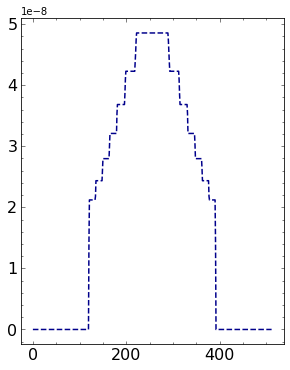

In [76]:
fig=plt.figure(figsize=(16, 6))
ax2=plt.subplot(131)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.plot(sst_jy[:,128].astype(np.float64), color='darkblue',label='MCFOST',linestyle='dashed')
ax2.plot(zo_file[0].data[:,128].astype(np.float64),c='m',label='Zodipic',linestyle='solid')
ax2.set_ylabel('SB in Jy ',fontsize=16)
ax2.set_xlabel('Pixels',fontsize=16)
ax2.set_title('Scattered star light',fontsize=16)
ax2.legend(loc='upper right',fontsize=16)

ax2=plt.subplot(132)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.plot(sst_jy[:,128].astype(np.float64)[100:150], c='dodgerblue',label='MCFOST',linestyle='dashed')
ax2.plot(zo_file[0].data[:,128].astype(np.float64)[100:150],c='crimson',label='Zodipic',linestyle='solid')
ax2.set_ylabel('SB in Jy ',fontsize=16)
ax2.set_xlabel('Pixels',fontsize=16)
ax2.set_title('Scattered star light',fontsize=16)
ax2.legend(loc='upper right',fontsize=16)

ax2=plt.subplot(133)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.plot(np.log10(sst_jy[129:256,128].astype(np.float64)), c='darkgreen',label='MCFOST',linestyle='dashed')
ax2.plot(np.log10(zo_file[0].data[129:256,128].astype(np.float64)),c='purple',label='Zodipic',linestyle='solid')
ax2.set_ylabel('log[SB] in Jy ',fontsize=16)
ax2.set_xlabel('Pixels',fontsize=16)
ax2.set_title('Scattered star light',fontsize=16)
ax2.legend(loc='upper right',fontsize=16)
fig.subplots_adjust(hspace=0.1, wspace=0.4, top=0.9, right=0.95)
#fig.savefig('/home/ramya/OneDrive/Debris-Disk-Modelling/Zodipic/'+'zodipic_inc75_pa266_ver3_crosssection.pdf', format='pdf', bbox_inches='tight')
